### Criar um modelo preditivo de preço para apartamentos na cidade de Porto Alegre

In [111]:
import numpy as np
import time
import pandas as pd
import plotly.plotly as py
import matplotlib.pyplot as plt
import seaborn as sns

# modelos de regressão
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

# para avaliação dos modelos
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

# na seção para identificar outliers
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

In [112]:
# leitura da base de dados
# inserir o nome do arquivo de acordo com o dia da coleta de dados
df = pd.read_csv('2019-01-20-foxter.csv', sep='\t', decimal=',')

# total of rows
df.shape[0]

577

In [113]:
df.head()

Unnamed: 0      id      price   area     district          city  \
0           0    5655        nan  70.26  Mont Serrat  Porto Alegre   
1           1    7932  720000.00  74.43  Mont Serrat  Porto Alegre   
2           2  121798  990000.00 104.83   Bela Vista  Porto Alegre   
3           3  151658 1450000.00 216.46  Auxiliadora  Porto Alegre   
4           4  176738 1900000.00 113.03  Auxiliadora  Porto Alegre   

          type      segment  condominium    iptu rooms  box  \
0  Apartamento  Residencial          nan     nan     2    2   
1  Apartamento  Residencial       717.00 1400.00     2    2   
2  Apartamento  Residencial       800.00 3070.00     3    2   
3  Apartamento  Residencial      1190.00 3100.00     3    1   
4  Apartamento  Residencial      1400.00 4300.00     3    3   

                                                 url        date  
0  http://www.foxterciaimobiliaria.com.br/imovel/...  2019-01-20  
1  http://www.foxterciaimobiliaria.com.br/imovel/...  2019-01-20  
2  http://www.foxterciaimobiliaria.com.br/imovel/...  2019-01-20  
3  http://www.foxterciaimobiliaria.com.br/imovel/...  2019-01-20  
4  http://www.foxterciaimobiliaria.com.br/imovel/...  2019-01-20

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 14 columns):
Unnamed: 0     577 non-null int64
id             577 non-null int64
price          443 non-null float64
area           576 non-null float64
district       577 non-null object
city           577 non-null object
type           577 non-null object
segment        573 non-null object
condominium    382 non-null float64
iptu           343 non-null float64
rooms          577 non-null object
box            577 non-null int64
url            577 non-null object
date           577 non-null object
dtypes: float64(4), int64(3), object(7)
memory usage: 63.2+ KB


In [115]:

'''
Identificação das colunas:

Unnamed - identificador
id - identificador
price - preço do imóvel em reais
area - área do imóvel em m2
district - bairro
city - cidade
type - tipo do imóvel (casa, apartamento, etc.)
segment - segmento a que pertence o imóvel (comercial, residencial, etc.)
condominium - valor em reais do condomínio
iptu - valor do iptu em reais
rooms - quantidade de quartos
box - quantidade de vagas na garagem
url - url da oferta do imóvel no site da imobiliária
date - data que foi coletada a oferta no site
'''


'\nIdentificação das colunas:\n\nUnnamed - identificador\nid - identificador\nprice - preço do imóvel em reais\narea - área do imóvel em m2\ndistrict - bairro\ncity - cidade\ntype - tipo do imóvel (casa, apartamento, etc.)\nsegment - segmento a que pertence o imóvel (comercial, residencial, etc.)\ncondominium - valor em reais do condomínio\niptu - valor do iptu em reais\nrooms - quantidade de quartos\nbox - quantidade de vagas na garagem\nurl - url da oferta do imóvel no site da imobiliária\ndate - data que foi coletada a oferta no site\n'

## Data Wrangle

In [116]:
# total de elementos únicos e repetidos

print ("total de elementos: " + str(df.shape[0]))
print ("total de elemento únicos: " + str(df.id.nunique()))
print ("elementos repetidos: " + str(df.shape[0] - df.id.nunique()))

total de elementos: 577
total de elemento únicos: 577
elementos repetidos: 0


In [117]:
# identificar duplicados

dupl = df[df.duplicated(['id'], keep=False)]['id']
dupl.sort_values()


Series([], Name: id, dtype: int64)

In [118]:
# apagar duplicados se houver
df = df.drop_duplicates(subset=['id'])
print ("elementos repetidos: " + str(df.shape[0] - df.id.nunique()))

elementos repetidos: 0


In [119]:
# Retirando colunas desnecessárias
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.drop(['id'], axis = 1, inplace = True)

In [120]:
# identificando os bairros
df.groupby(['district']).count()

# -> há imóveis sem preço

price  area  city  type  segment  condominium  iptu  rooms  box  \
district                                                                        
Auxiliadora     203   259   259   259      258          155   141    259  259   
Bela Vista      144   192   193   193      190          137   123    193  193   
Boa Vista         7     7     7     7        7            7     7      7    7   
Higienópolis      1     1     1     1        1            1     1      1    1   
Menino Deus       0     1     1     1        1            0     0      1    1   
Mont Serrat      87   114   114   114      114           81    70    114  114   
Mont'Serrat       0     1     1     1        1            0     0      1    1   
Petrópolis        1     1     1     1        1            1     1      1    1   

              url  date  
district                 
Auxiliadora   259   259  
Bela Vista    193   193  
Boa Vista       7     7  
Higienópolis    1     1  
Menino Deus     1     1  
Mont Serrat   114   114  
Mont'Serrat     1     1  
Petrópolis      1     1

In [121]:
# Corrigir os nomes dos bairros errados
df['district'] = df['district'].replace("Mont'Serrat", "Mont Serrat")


# manter apenas Auxiliadora, Bela Vista e Mont Serrat
df = df.drop(df.query("(district != 'Mont Serrat' & district != 'Auxiliadora' & district != 'Bela Vista')").index)
df.groupby(['district']).count()

price  area  city  type  segment  condominium  iptu  rooms  box  \
district                                                                       
Auxiliadora    203   259   259   259      258          155   141    259  259   
Bela Vista     144   192   193   193      190          137   123    193  193   
Mont Serrat     87   115   115   115      115           81    70    115  115   

             url  date  
district                
Auxiliadora  259   259  
Bela Vista   193   193  
Mont Serrat  115   115

In [122]:
# identificar e retirar cidades que não sejam Porto Alegre
df.groupby(['city']).count()

price  area  district  type  segment  condominium  iptu  rooms  \
city                                                                           
Porto Alegre    434   566       567   567      563          373   334    567   

              box  url  date  
city                          
Porto Alegre  567  567   567

In [123]:
# identificar e manter somente os imóveis do tipo "apartamentos"
df.groupby(['type']).count()

price  area  district  city  segment  condominium  iptu  rooms  \
type                                                                          
Apartamento    434   566       567   567      563          373   334    567   

             box  url  date  
type                         
Apartamento  567  567   567

In [124]:
df = df.drop(df.query('(type != "Apartamento")').index)
df.groupby(['type']).count()

price  area  district  city  segment  condominium  iptu  rooms  \
type                                                                          
Apartamento    434   566       567   567      563          373   334    567   

             box  url  date  
type                         
Apartamento  567  567   567

In [125]:
# identificar e manter somente os imóveis do segmento "Residencial"
df.groupby(['segment']).count()

price  area  district  city  type  condominium  iptu  \
segment                                                                        
Comercial, Residencial      1     2         2     2     2            1     1   
Residencial               429   560       561   561   561          368   329   

                        rooms  box  url  date  
segment                                        
Comercial, Residencial      2    2    2     2  
Residencial               561  561  561   561

In [126]:
df = df.drop(df.query('(segment != "Residencial")').index)
df.groupby(['segment']).count()

price  area  district  city  type  condominium  iptu  rooms  box  \
segment                                                                         
Residencial    429   560       561   561   561          368   329    561  561   

             url  date  
segment                 
Residencial  561   561

In [127]:
# ajustar os valroes da variável rooms
df.groupby(['rooms']).count()

price  area  district  city  type  segment  \
rooms                                                                 
\n 0\n 1\n 2\n 3\n 4+\n      0     1         1     1     1        1   
1                           56    67        67    67    67       67   
2                          109   144       144   144   144      144   
3                          223   304       305   305   305      305   
4                           38    41        41    41    41       41   
5                            2     2         2     2     2        2   
6                            1     1         1     1     1        1   

                         condominium  iptu  box  url  date  
rooms                                                       
\n 0\n 1\n 2\n 3\n 4+\n            0     0    1    1     1  
1                                 43    39   67   67    67  
2                                 95    85  144  144   144  
3                                194   176  305  305   305  
4                                 33    26   41   41    41  
5                                  2     2    2    2     2  
6                                  1     1    1    1     1

In [128]:
# errors='coerce' o que não puder ser transformado vai virar NaN
df['rooms'] = pd.to_numeric(df['rooms'], downcast='integer', errors='coerce')
df.groupby(['rooms']).count()

price  area  district  city  type  segment  condominium  iptu  box  \
rooms                                                                       
1.00      56    67        67    67    67       67           43    39   67   
2.00     109   144       144   144   144      144           95    85  144   
3.00     223   304       305   305   305      305          194   176  305   
4.00      38    41        41    41    41       41           33    26   41   
5.00       2     2         2     2     2        2            2     2    2   
6.00       1     1         1     1     1        1            1     1    1   

       url  date  
rooms             
1.00    67    67  
2.00   144   144  
3.00   305   305  
4.00    41    41  
5.00     2     2  
6.00     1     1

In [129]:
# identificando a quantidade de categorias e seus totais em "box"
df['box'].value_counts(dropna=False)

1    255
2    232
3     61
4     12
8      1
Name: box, dtype: int64

In [130]:
# Retirando colunas desnecessárias
df.drop(['city'], axis = 1, inplace = True)
df.drop(['type'], axis = 1, inplace = True)
df.drop(['segment'], axis = 1, inplace = True)
df.drop(['url'], axis = 1, inplace = True)
df.drop(['date'], axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561 entries, 0 to 576
Data columns (total 7 columns):
price          429 non-null float64
area           560 non-null float64
district       561 non-null object
condominium    368 non-null float64
iptu           329 non-null float64
rooms          560 non-null float64
box            561 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 35.1+ KB


In [131]:
# removendo todos os NaN
df = df.dropna()

miss = df.isnull().sum(axis=0) 
print ("quantidade de missing values: "+str(miss.sum()))


quantidade de missing values: 0


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326 entries, 1 to 576
Data columns (total 7 columns):
price          326 non-null float64
area           326 non-null float64
district       326 non-null object
condominium    326 non-null float64
iptu           326 non-null float64
rooms          326 non-null float64
box            326 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 20.4+ KB


In [133]:
# Convertendo as variáveis para os formatos corretos
df['rooms'] = df['rooms'].astype(int)
df['district'] = df['district'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326 entries, 1 to 576
Data columns (total 7 columns):
price          326 non-null float64
area           326 non-null float64
district       326 non-null category
condominium    326 non-null float64
iptu           326 non-null float64
rooms          326 non-null int64
box            326 non-null int64
dtypes: category(1), float64(4), int64(2)
memory usage: 18.2 KB


### Identificar outliers

In [134]:
# boxplot para identificar outliers na variável preço

x = df.district

trace0 = go.Box(
    y=df.price,
    x=x,
    name='kale',
    marker=dict(
        color='blue'
    )
)

data = [trace0]
layout = go.Layout(
    yaxis=dict(
        title='preço de venda',
        zeroline=False
    ),
    boxmode='group'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Limite para corte dos outliers: 3200000.0


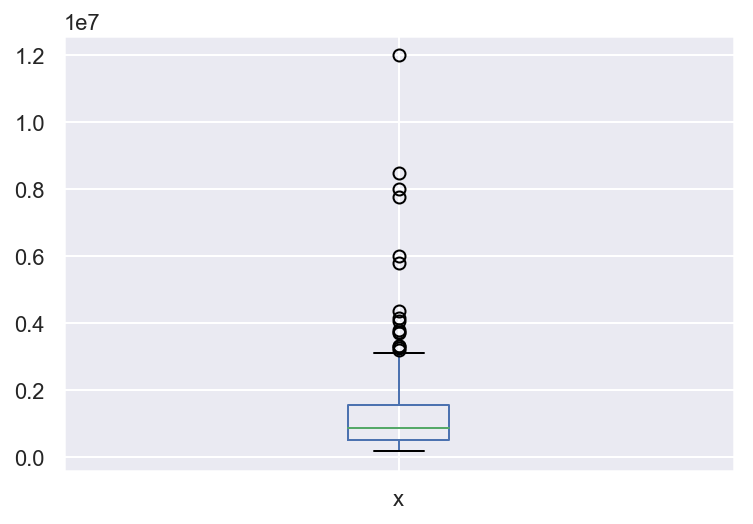

In [135]:
# para encontrar os valores do boxplot preço
# https://stackoverflow.com/questions/33518472/getting-data-of-a-boxplot-pandas?rq=1

_, bp = pd.DataFrame.boxplot(df['price'], return_type='both')

outliers = [flier.get_ydata() for flier in bp["fliers"]]
boxes = [box.get_ydata() for box in bp["boxes"]]
medians = [median.get_ydata() for median in bp["medians"]]
whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]

min_outliers = outliers[0].min()
print ("Limite para corte dos outliers:", min_outliers)

# retirar os outliers
df = df.loc[df['price'] < min_outliers]

In [136]:
# boxplot área

x = df.district

trace0 = go.Box(
    y=df.area,
    x=x,
    name='kale',
    marker=dict(
        color='blue'
    )
)

data = [trace0]
layout = go.Layout(
    yaxis=dict(
        title='área',
        zeroline=False
    ),
    boxmode='group'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Limite para corte dos outliers: 283.526


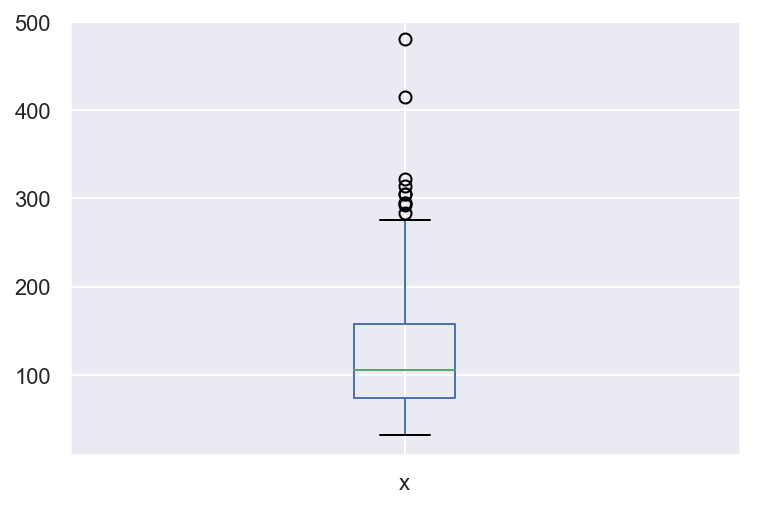

In [137]:
# para encontrar os valores do boxplot área
_, bp = pd.DataFrame.boxplot(df['area'], return_type='both')

outliers = [flier.get_ydata() for flier in bp["fliers"]]
boxes = [box.get_ydata() for box in bp["boxes"]]
medians = [median.get_ydata() for median in bp["medians"]]
whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]

min_outliers = outliers[0].min()
print ("Limite para corte dos outliers:", min_outliers)

# retirar os outliers
df = df.loc[df['area'] < min_outliers]

In [138]:
# boxplot: valor do condomínio

x = df.district

trace0 = go.Box(
    y=df.condominium,
    x=x,
    name='kale',
    marker=dict(
        color='blue'
    )
)

data = [trace0]
layout = go.Layout(
    yaxis=dict(
        title='valor do condomínio',
        zeroline=False
    ),
    boxmode='group'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Limite para corte dos outliers: 2500.0


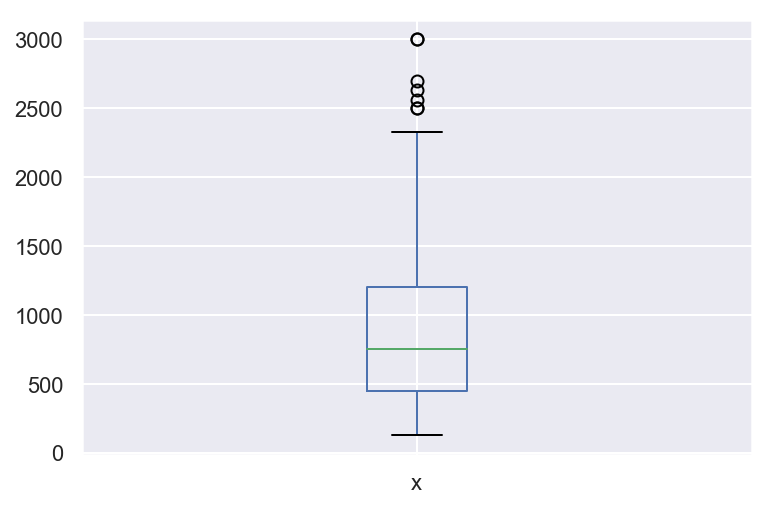

In [139]:
# para encontrar os valores do boxplot
_, bp = pd.DataFrame.boxplot(df['condominium'], return_type='both')

outliers = [flier.get_ydata() for flier in bp["fliers"]]
boxes = [box.get_ydata() for box in bp["boxes"]]
medians = [median.get_ydata() for median in bp["medians"]]
whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]

min_outliers = outliers[0].min()
print ("Limite para corte dos outliers:", min_outliers)

# retirar os outliers
df = df.loc[df['condominium'] < min_outliers]

In [140]:
# Boxplot do iptu
x = df.district

trace0 = go.Box(
    y=df.iptu,
    x=x,
    name='kale',
    marker=dict(
        color='blue'
    )
)

data = [trace0]
layout = go.Layout(
    yaxis=dict(
        title='valor do iptu',
        zeroline=False
    ),
    boxmode='group'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Limite para corte dos outliers: 5500.0


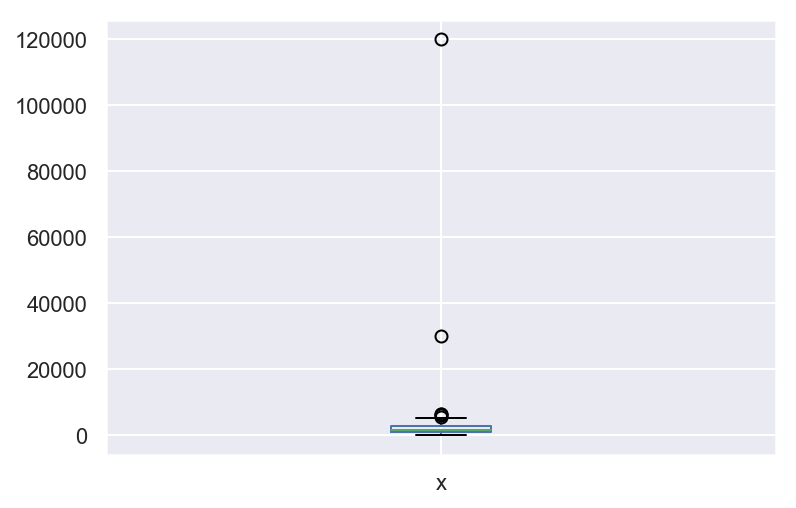

In [141]:
# para encontrar os valores do boxplot
sns.set()
_, bp = pd.DataFrame.boxplot(df['iptu'], return_type='both')

outliers = [flier.get_ydata() for flier in bp["fliers"]]
boxes = [box.get_ydata() for box in bp["boxes"]]
medians = [median.get_ydata() for median in bp["medians"]]
whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]

min_outliers = outliers[0].min()
print ("Limite para corte dos outliers:", min_outliers)

# retirar os outliers
df = df.loc[df['iptu'] < min_outliers]



# EDA - Exploratory Data Analysis


In [142]:
# Total de ofertas
df.shape[0]

287

In [143]:
# Variáveis
df.info()
print('\n\nVariáveis: ', list(df))
print('Total: ',df.shape[1])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 1 to 576
Data columns (total 7 columns):
price          287 non-null float64
area           287 non-null float64
district       287 non-null category
condominium    287 non-null float64
iptu           287 non-null float64
rooms          287 non-null int64
box            287 non-null int64
dtypes: category(1), float64(4), int64(2)
memory usage: 16.1 KB


Variáveis:  ['price', 'area', 'district', 'condominium', 'iptu', 'rooms', 'box']
Total:  7


In [144]:
# Uma variável "target" quantitativa contínua: preço

target = ['price']

In [145]:
# Features quantitativas
features_quanti = list(set(list(df.select_dtypes(include=['float64', 'int64']).columns)) - set(target))
print('Features quantitativas: ', features_quanti)
print('Total: ', len(features_quanti))

Features quantitativas:  ['box', 'rooms', 'iptu', 'condominium', 'area']
Total:  5


In [146]:
# Feature categórica
features_cat = list(df.select_dtypes(include=['category']).columns)
print('Feature categórica: ', features_cat)
print('Total: ', len(features_cat))

Feature categórica:  ['district']
Total:  1


In [147]:
# Todas as features

features_list = features_quanti + features_cat
print(features_list)

['box', 'rooms', 'iptu', 'condominium', 'area', 'district']


### Seção Univariada

In [148]:
# Descrição das variáveis quantitativas
df.describe()

price   area  condominium    iptu  rooms    box
count     287.00 287.00       287.00  287.00 287.00 287.00
mean   913783.59 113.66       842.99 1875.40   2.47   1.60
std    579992.70  52.32       501.85 1215.94   0.77   0.61
min    180000.00  32.00       130.00   43.00   1.00   1.00
25%    480000.00  72.88       440.00  995.00   2.00   1.00
50%    735000.00 101.72       750.00 1500.00   3.00   2.00
75%   1200000.00 144.26      1200.00 2624.00   3.00   2.00
max   3001000.00 267.34      2330.00 5200.00   4.00   3.00

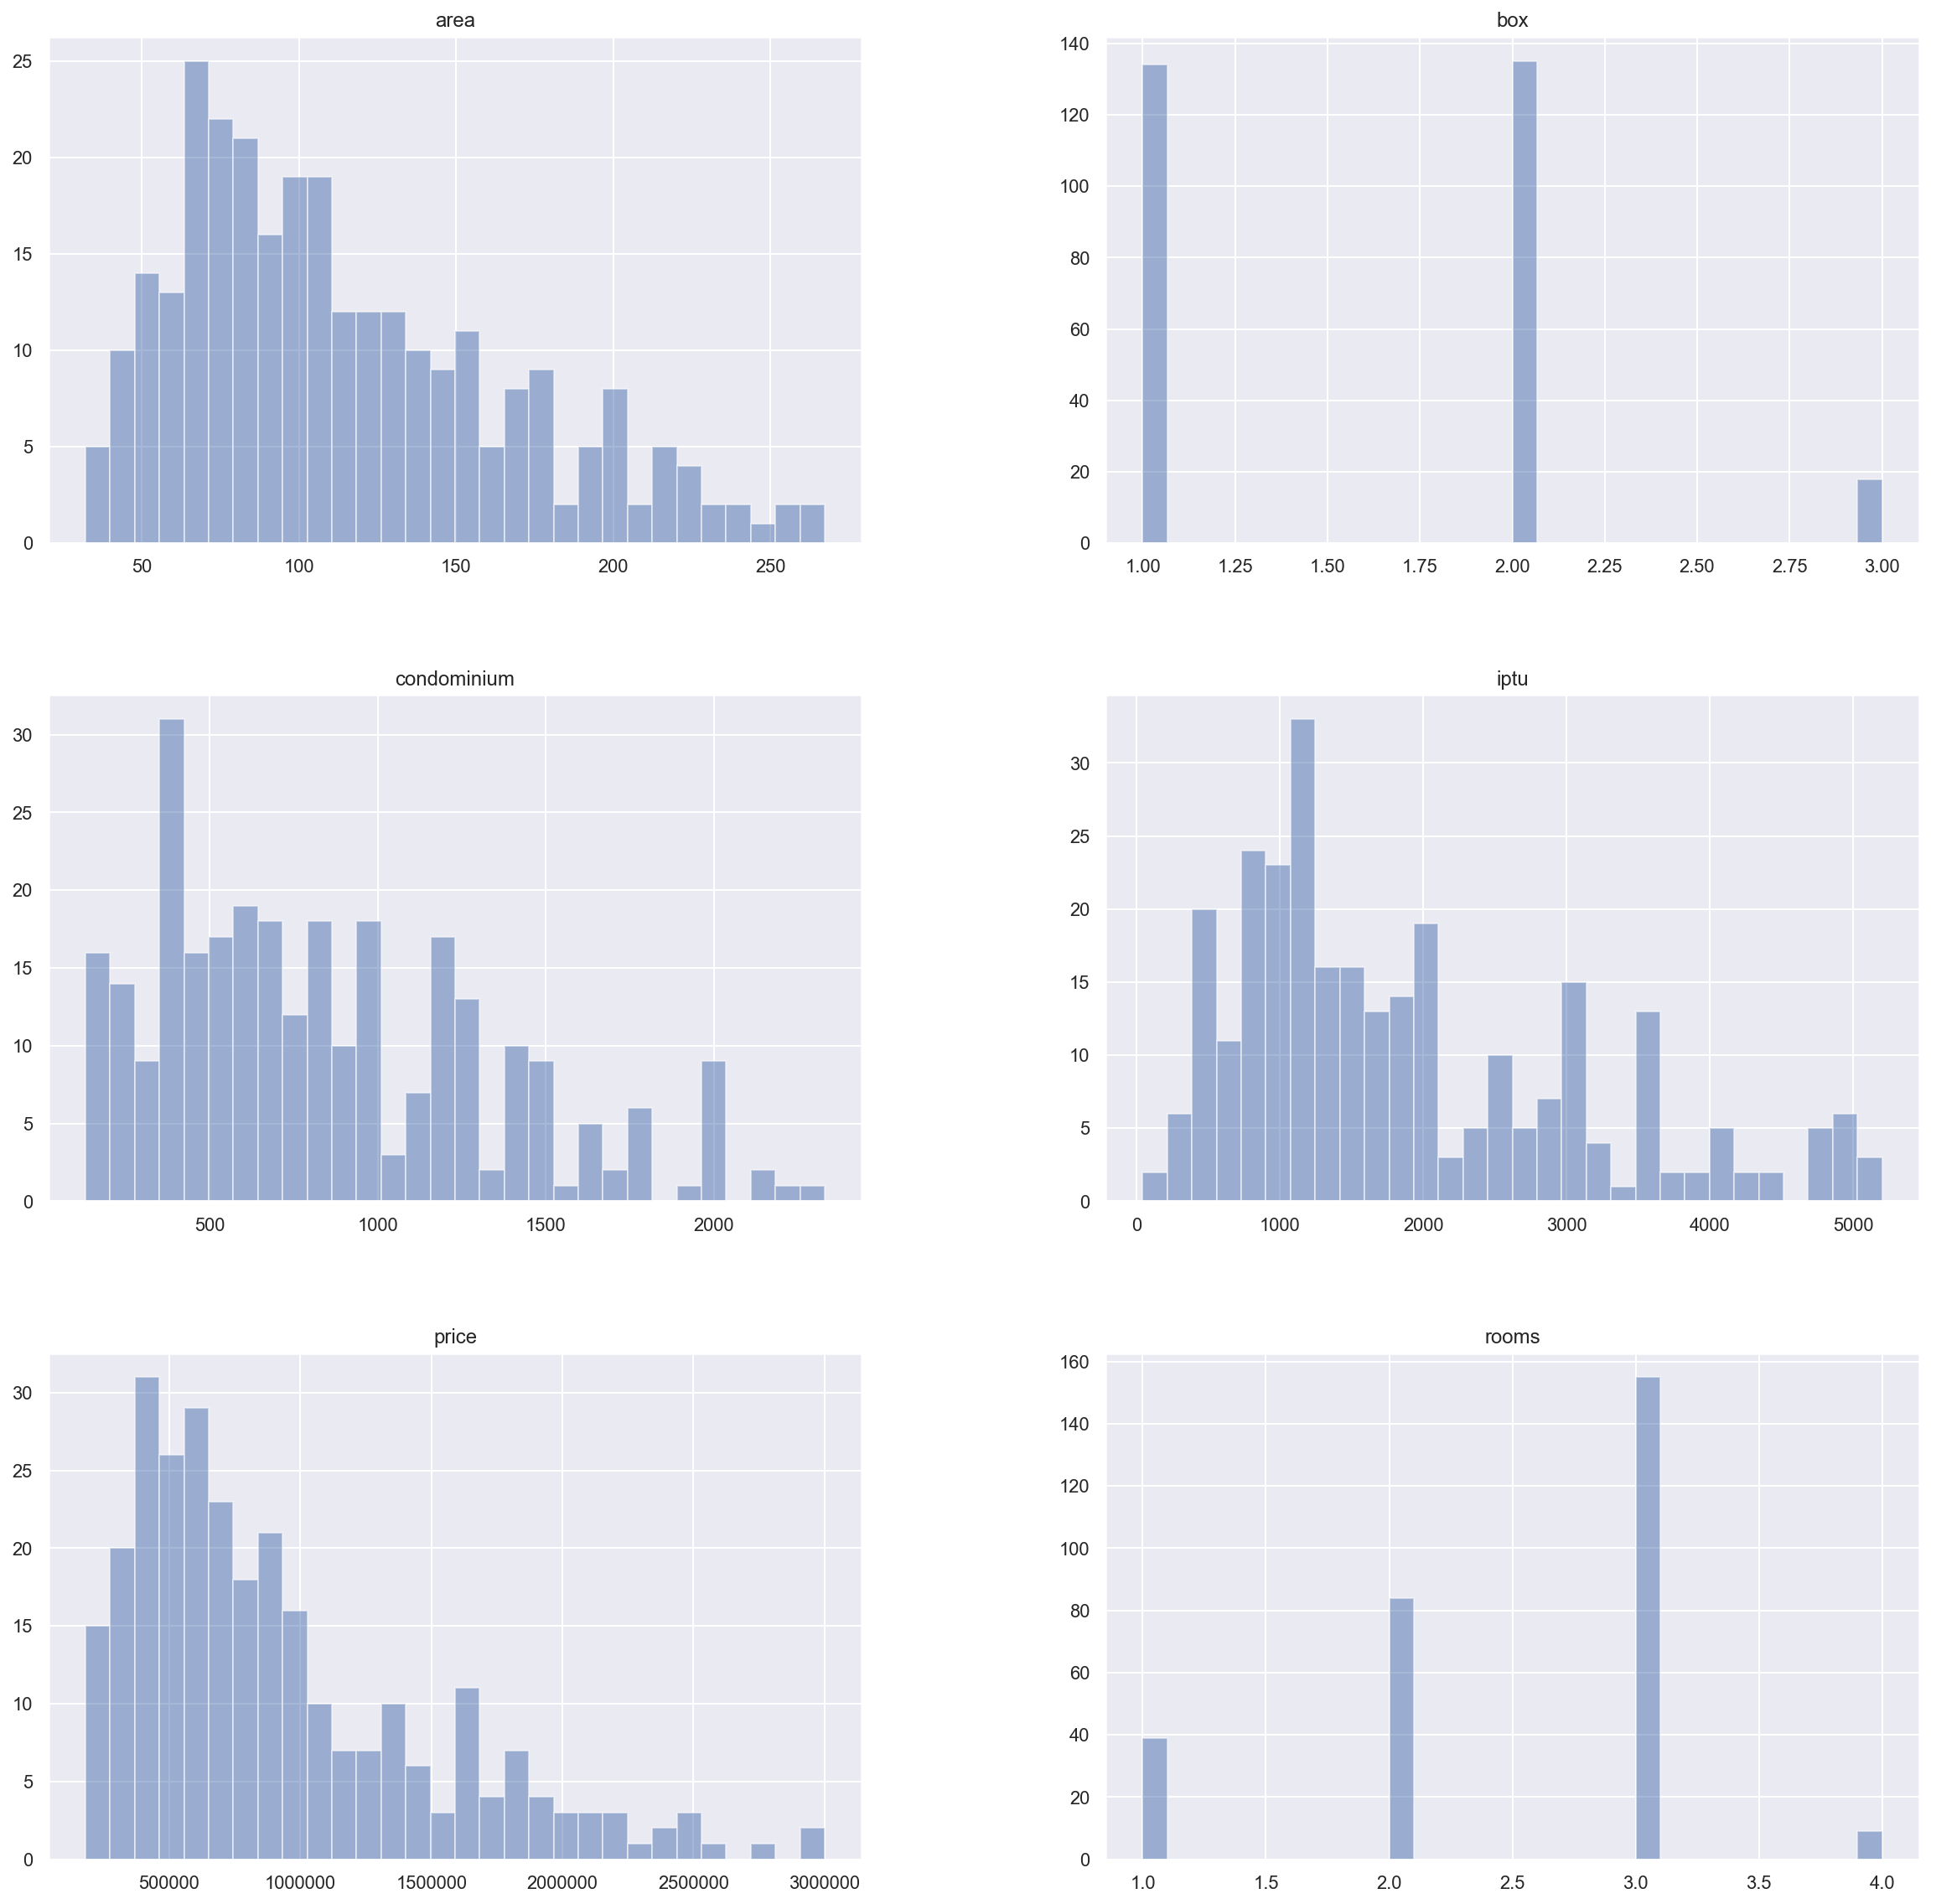

In [149]:
# Histogramas
sns.set()
quanti_hist = list(df.select_dtypes(include=['float64', 'int64']).columns)
df[quanti_hist].hist(layout=(int(len(quanti_hist)/2),2), alpha=0.5, bins=30, figsize=(20, 20))
plt.show()

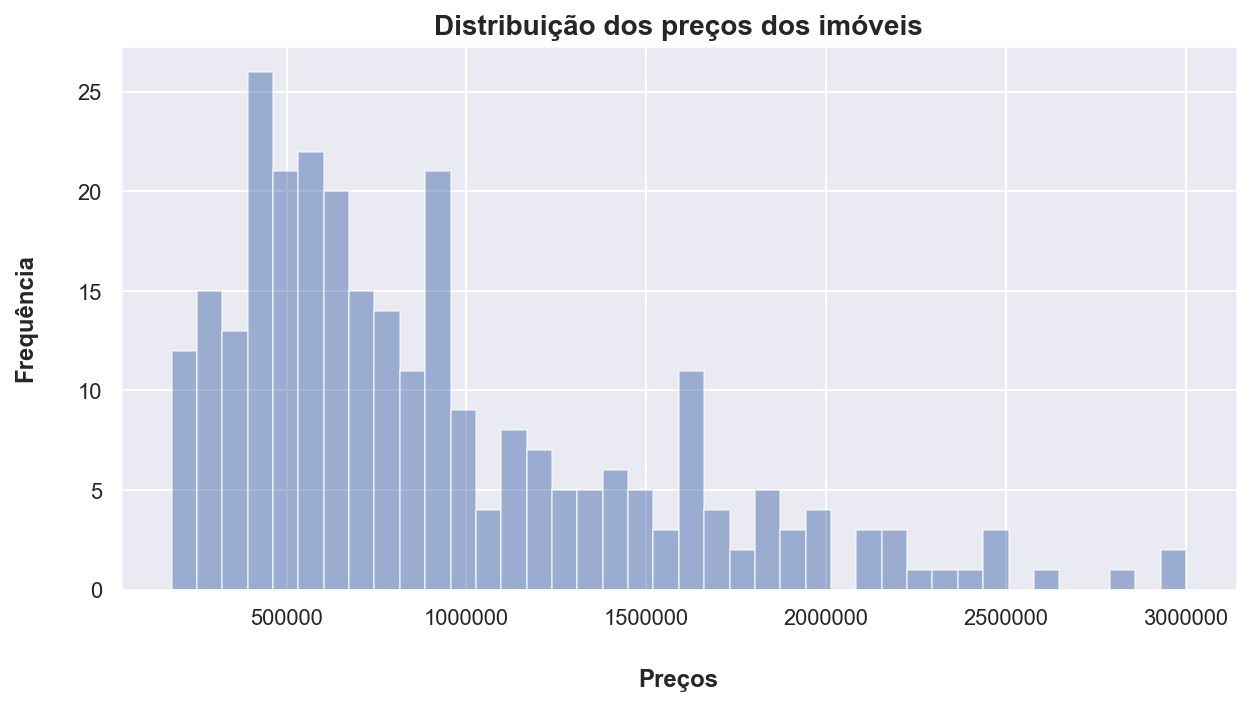

In [150]:
# Histograma: preço
sns.set()
ax = df['price'].plot.hist(bins=40, alpha=0.5, figsize=(10, 5))
ax.set_title('Distribuição dos preços dos imóveis', weight='bold', size=14)
ax.set_ylabel("Frequência", labelpad=20, weight='bold', size=12)
ax.set_xlabel('Preços', labelpad=20, weight='bold', size=12)
plt.show()

In [151]:
# Descrição da variável qualitativa
df.describe(include=['category'])

district
count           287
unique            3
top     Auxiliadora
freq            125

In [152]:
# Quantidade por bairro
df['district'].value_counts()

Auxiliadora    125
Bela Vista      95
Mont Serrat     67
Name: district, dtype: int64

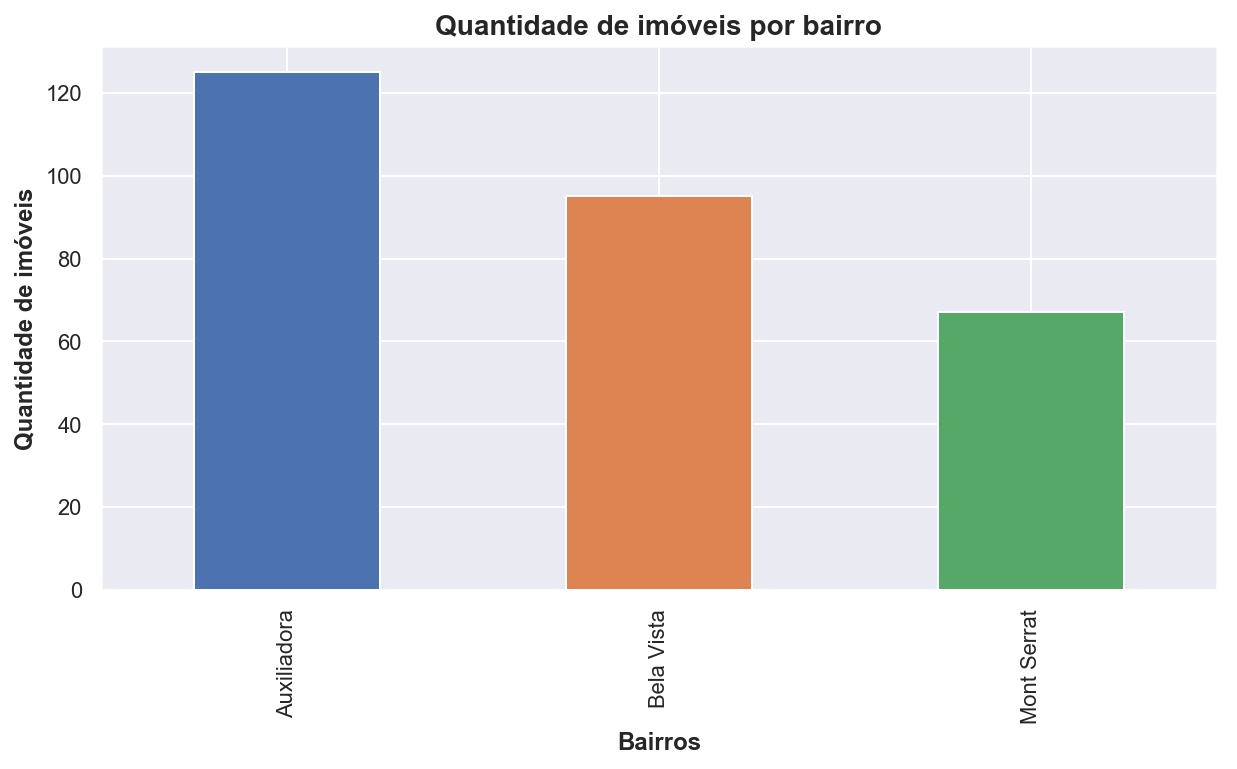

In [153]:
sns.set()
ax = df['district'].value_counts().plot.bar(figsize=(10, 5))
ax.set_title('Quantidade de imóveis por bairro', weight='bold', size=14)
ax.set_ylabel('Quantidade de imóveis', weight='bold', size=12)
ax.set_xlabel('Bairros', weight='bold', size=12)
plt.show()

### Seção de Gráficos Bivariados

In [154]:

pd.set_option('display.float_format', lambda x: '%.2f' % x)

pd.pivot_table(df, index=["district"],aggfunc={
    "price":np.mean, 
    "area":np.mean, 
    "condominium":np.mean, 
    "rooms":np.mean, 
    "box":np.mean, 
    "iptu":np.mean})

area  box  condominium    iptu      price  rooms
district                                                      
Auxiliadora 110.88 1.60       796.66 1778.84  859152.22   2.49
Bela Vista  125.94 1.62       937.54 2149.37 1090082.76   2.51
Mont Serrat 101.43 1.55       795.34 1667.09  765731.34   2.37

### Bairro x Quantidade de Quartos

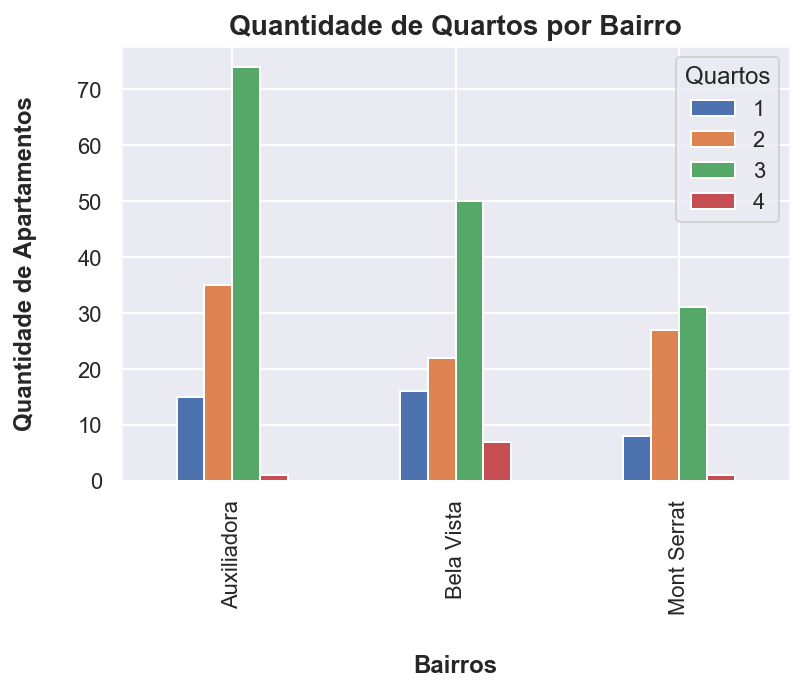

In [155]:
sns.set()
cr = pd.crosstab(df['district'], df['rooms'])
ax = cr.plot.bar()
ax.legend(title="Quartos")
ax.set_title('Quantidade de Quartos por Bairro', weight='bold', size=14)
ax.set_ylabel("Quantidade de Apartamentos", labelpad=20, weight='bold', size=12)
ax.set_xlabel('Bairros', labelpad=20, weight='bold', size=12)
plt.show()

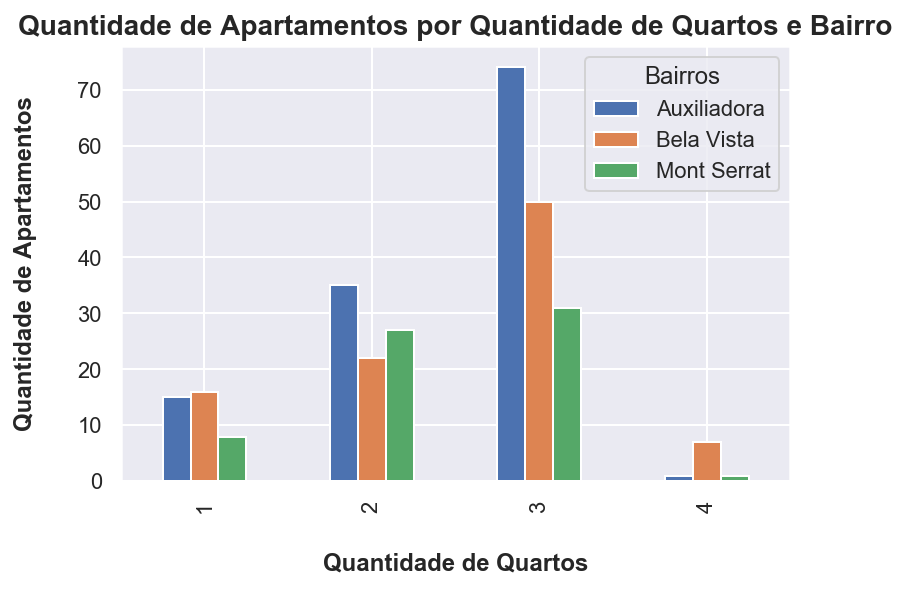

In [156]:
sns.set()
cr = pd.crosstab(df['rooms'], df['district'])
ax = cr.plot.bar()
ax.legend(title="Bairros")
ax.set_title('Quantidade de Apartamentos por Quantidade de Quartos e Bairro', weight='bold', size=14)
ax.set_ylabel("Quantidade de Apartamentos", labelpad=20, weight='bold', size=12)
ax.set_xlabel('Quantidade de Quartos', labelpad=20, weight='bold', size=12)
plt.show()

In [157]:
# Quantiade: Vagas de quartos x Bairros

pd.pivot_table(df, index=["rooms"], columns=["district"], values=["price"], aggfunc=len, margins=True)#.stack('district')

price                              
district Auxiliadora Bela Vista Mont Serrat    All
rooms                                             
1              15.00      16.00        8.00  39.00
2              35.00      22.00       27.00  84.00
3              74.00      50.00       31.00 155.00
4               1.00       7.00        1.00   9.00
All           125.00      95.00       67.00 287.00

In [158]:
pd.DataFrame.groupby(df['rooms'], df['district']).describe()

count  mean  std  min  25%  50%  75%  max
district                                              
Auxiliadora 125.00  2.49 0.71 1.00 2.00 3.00 3.00 4.00
Bela Vista   95.00  2.51 0.86 1.00 2.00 3.00 3.00 4.00
Mont Serrat  67.00  2.37 0.71 1.00 2.00 2.00 3.00 4.00

### Garagens x Bairro

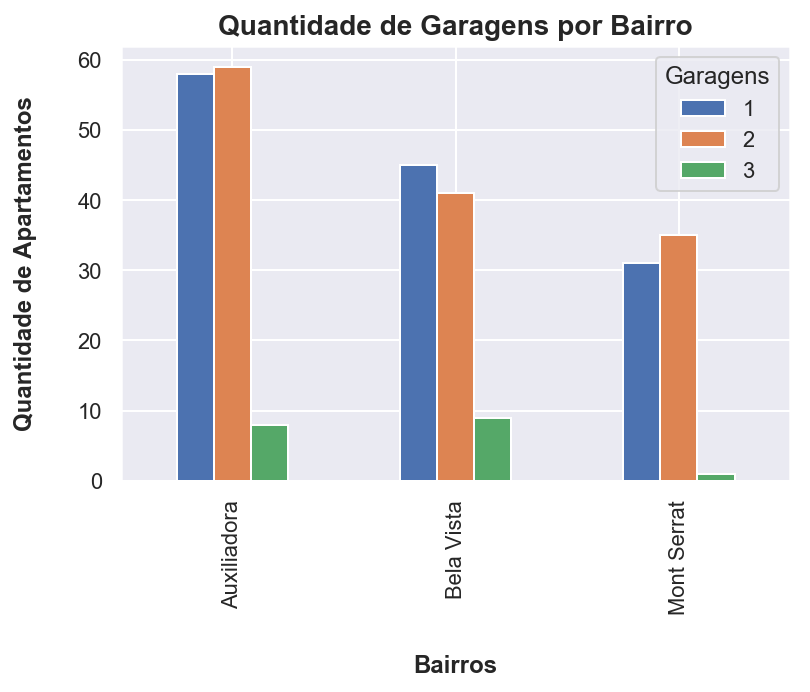

In [159]:
sns.set()
cr = pd.crosstab(df['district'], df['box'])
ax = cr.plot.bar()
ax.legend(title="Garagens")
ax.set_title('Quantidade de Garagens por Bairro', weight='bold', size=14)
ax.set_ylabel("Quantidade de Apartamentos", labelpad=20, weight='bold', size=12)
ax.set_xlabel('Bairros', labelpad=20, weight='bold', size=12)
plt.show()

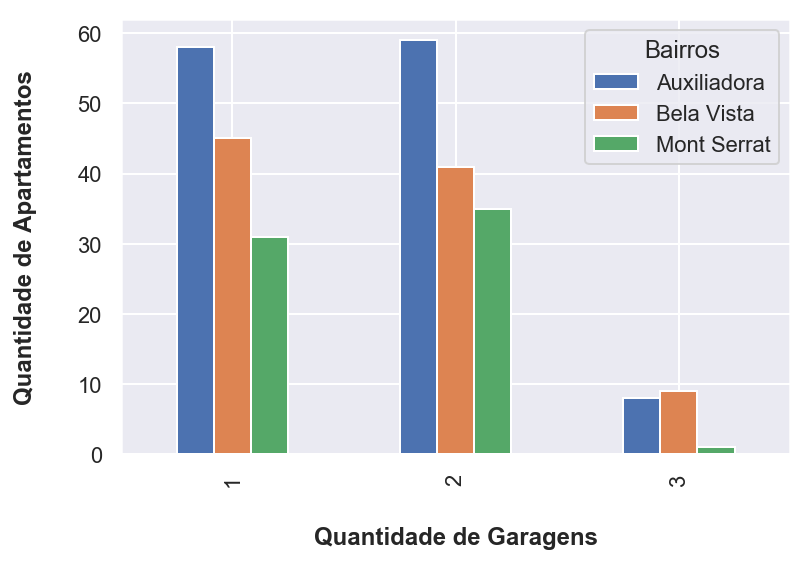

In [160]:
sns.set()
cr = pd.crosstab(df['box'], df['district'])
ax = cr.plot.bar()
ax.legend(title="Bairros")
#ax.set_title('Bairros por Quantidade de Garagens', weight='bold', size=14)
ax.set_ylabel("Quantidade de Apartamentos", labelpad=20, weight='bold', size=12)
ax.set_xlabel('Quantidade de Garagens', labelpad=20, weight='bold', size=12)
plt.show()

In [161]:
# Quantiade: Vagas de garagem x Bairros

pd.pivot_table(df, index=["box"], columns=["district"], values=["price"], aggfunc=len, margins=True)#.stack('district')

price                              
district Auxiliadora Bela Vista Mont Serrat    All
box                                               
1              58.00      45.00       31.00 134.00
2              59.00      41.00       35.00 135.00
3               8.00       9.00        1.00  18.00
All           125.00      95.00       67.00 287.00

In [162]:
pd.DataFrame.groupby(df['box'], df['district']).describe()

count  mean  std  min  25%  50%  75%  max
district                                              
Auxiliadora 125.00  1.60 0.61 1.00 1.00 2.00 2.00 3.00
Bela Vista   95.00  1.62 0.66 1.00 1.00 2.00 2.00 3.00
Mont Serrat  67.00  1.55 0.53 1.00 1.00 2.00 2.00 3.00

In [163]:
# boxplot: preço

x = df.district

trace0 = go.Box(
    y=df.price,
    x=x,
    name='kale',
    marker=dict(
        color='blue'
    )
)

data = [trace0]
layout = go.Layout(
    yaxis=dict(
        title='preço de venda',
        zeroline=False
    ),
    boxmode='group'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [164]:
pd.DataFrame.groupby(df['price'], df['district']).describe()

count       mean       std       min       25%       50%  \
district                                                                
Auxiliadora 125.00  859152.22 578902.68 185000.00 460000.00 660000.00   
Bela Vista   95.00 1090082.76 632531.82 180000.00 604500.00 920000.00   
Mont Serrat  67.00  765731.34 430795.34 244000.00 435000.00 698000.00   

                   75%        max  
district                           
Auxiliadora 1150000.00 2940000.00  
Bela Vista  1599500.00 3001000.00  
Mont Serrat  947000.00 2470000.00

In [165]:
# boxplot área

x = df.district

trace0 = go.Box(
    y=df.area,
    x=x,
    name='kale',
    marker=dict(
        color='blue'
    )
)

data = [trace0]
layout = go.Layout(
    yaxis=dict(
        title='área',
        zeroline=False
    ),
    boxmode='group'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [166]:
pd.DataFrame.groupby(df['area'], df['district']).describe()

count   mean   std   min   25%    50%    75%    max
district                                                        
Auxiliadora 125.00 110.88 51.28 32.00 72.09  98.61 136.00 267.34
Bela Vista   95.00 125.94 57.64 32.13 80.30 113.10 167.95 257.60
Mont Serrat  67.00 101.43 42.49 39.77 70.85  89.38 134.72 213.10

In [167]:
# boxplot: valor do condomínio

x = df.district

trace0 = go.Box(
    y=df.condominium,
    x=x,
    name='kale',
    marker=dict(
        color='blue'
    )
)

data = [trace0]
layout = go.Layout(
    yaxis=dict(
        title='valor do condomínio',
        zeroline=False
    ),
    boxmode='group'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [168]:
pd.DataFrame.groupby(df['condominium'], df['district']).describe()

count   mean    std    min    25%    50%     75%     max
district                                                             
Auxiliadora 125.00 796.66 531.07 180.00 400.00 601.00 1190.00 2330.00
Bela Vista   95.00 937.54 511.08 140.00 500.00 900.00 1300.00 2000.00
Mont Serrat  67.00 795.34 412.57 130.00 450.00 730.00 1051.50 2150.00

In [169]:
# Boxplot do iptu
x = df.district

trace0 = go.Box(
    y=df.iptu,
    x=x,
    name='kale',
    marker=dict(
        color='blue'
    )
)

data = [trace0]
layout = go.Layout(
    yaxis=dict(
        title='valor do iptu',
        zeroline=False
    ),
    boxmode='group'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [170]:
pd.DataFrame.groupby(df['iptu'], df['district']).describe()

count    mean     std    min     25%     50%     75%     max
district                                                                 
Auxiliadora 125.00 1778.84 1194.30 252.00  930.00 1400.00 2288.00 5200.00
Bela Vista   95.00 2149.37 1328.14  43.00 1099.00 1900.00 3035.00 5200.00
Mont Serrat  67.00 1667.09 1022.28 312.00  970.00 1350.00 2450.00 5000.00

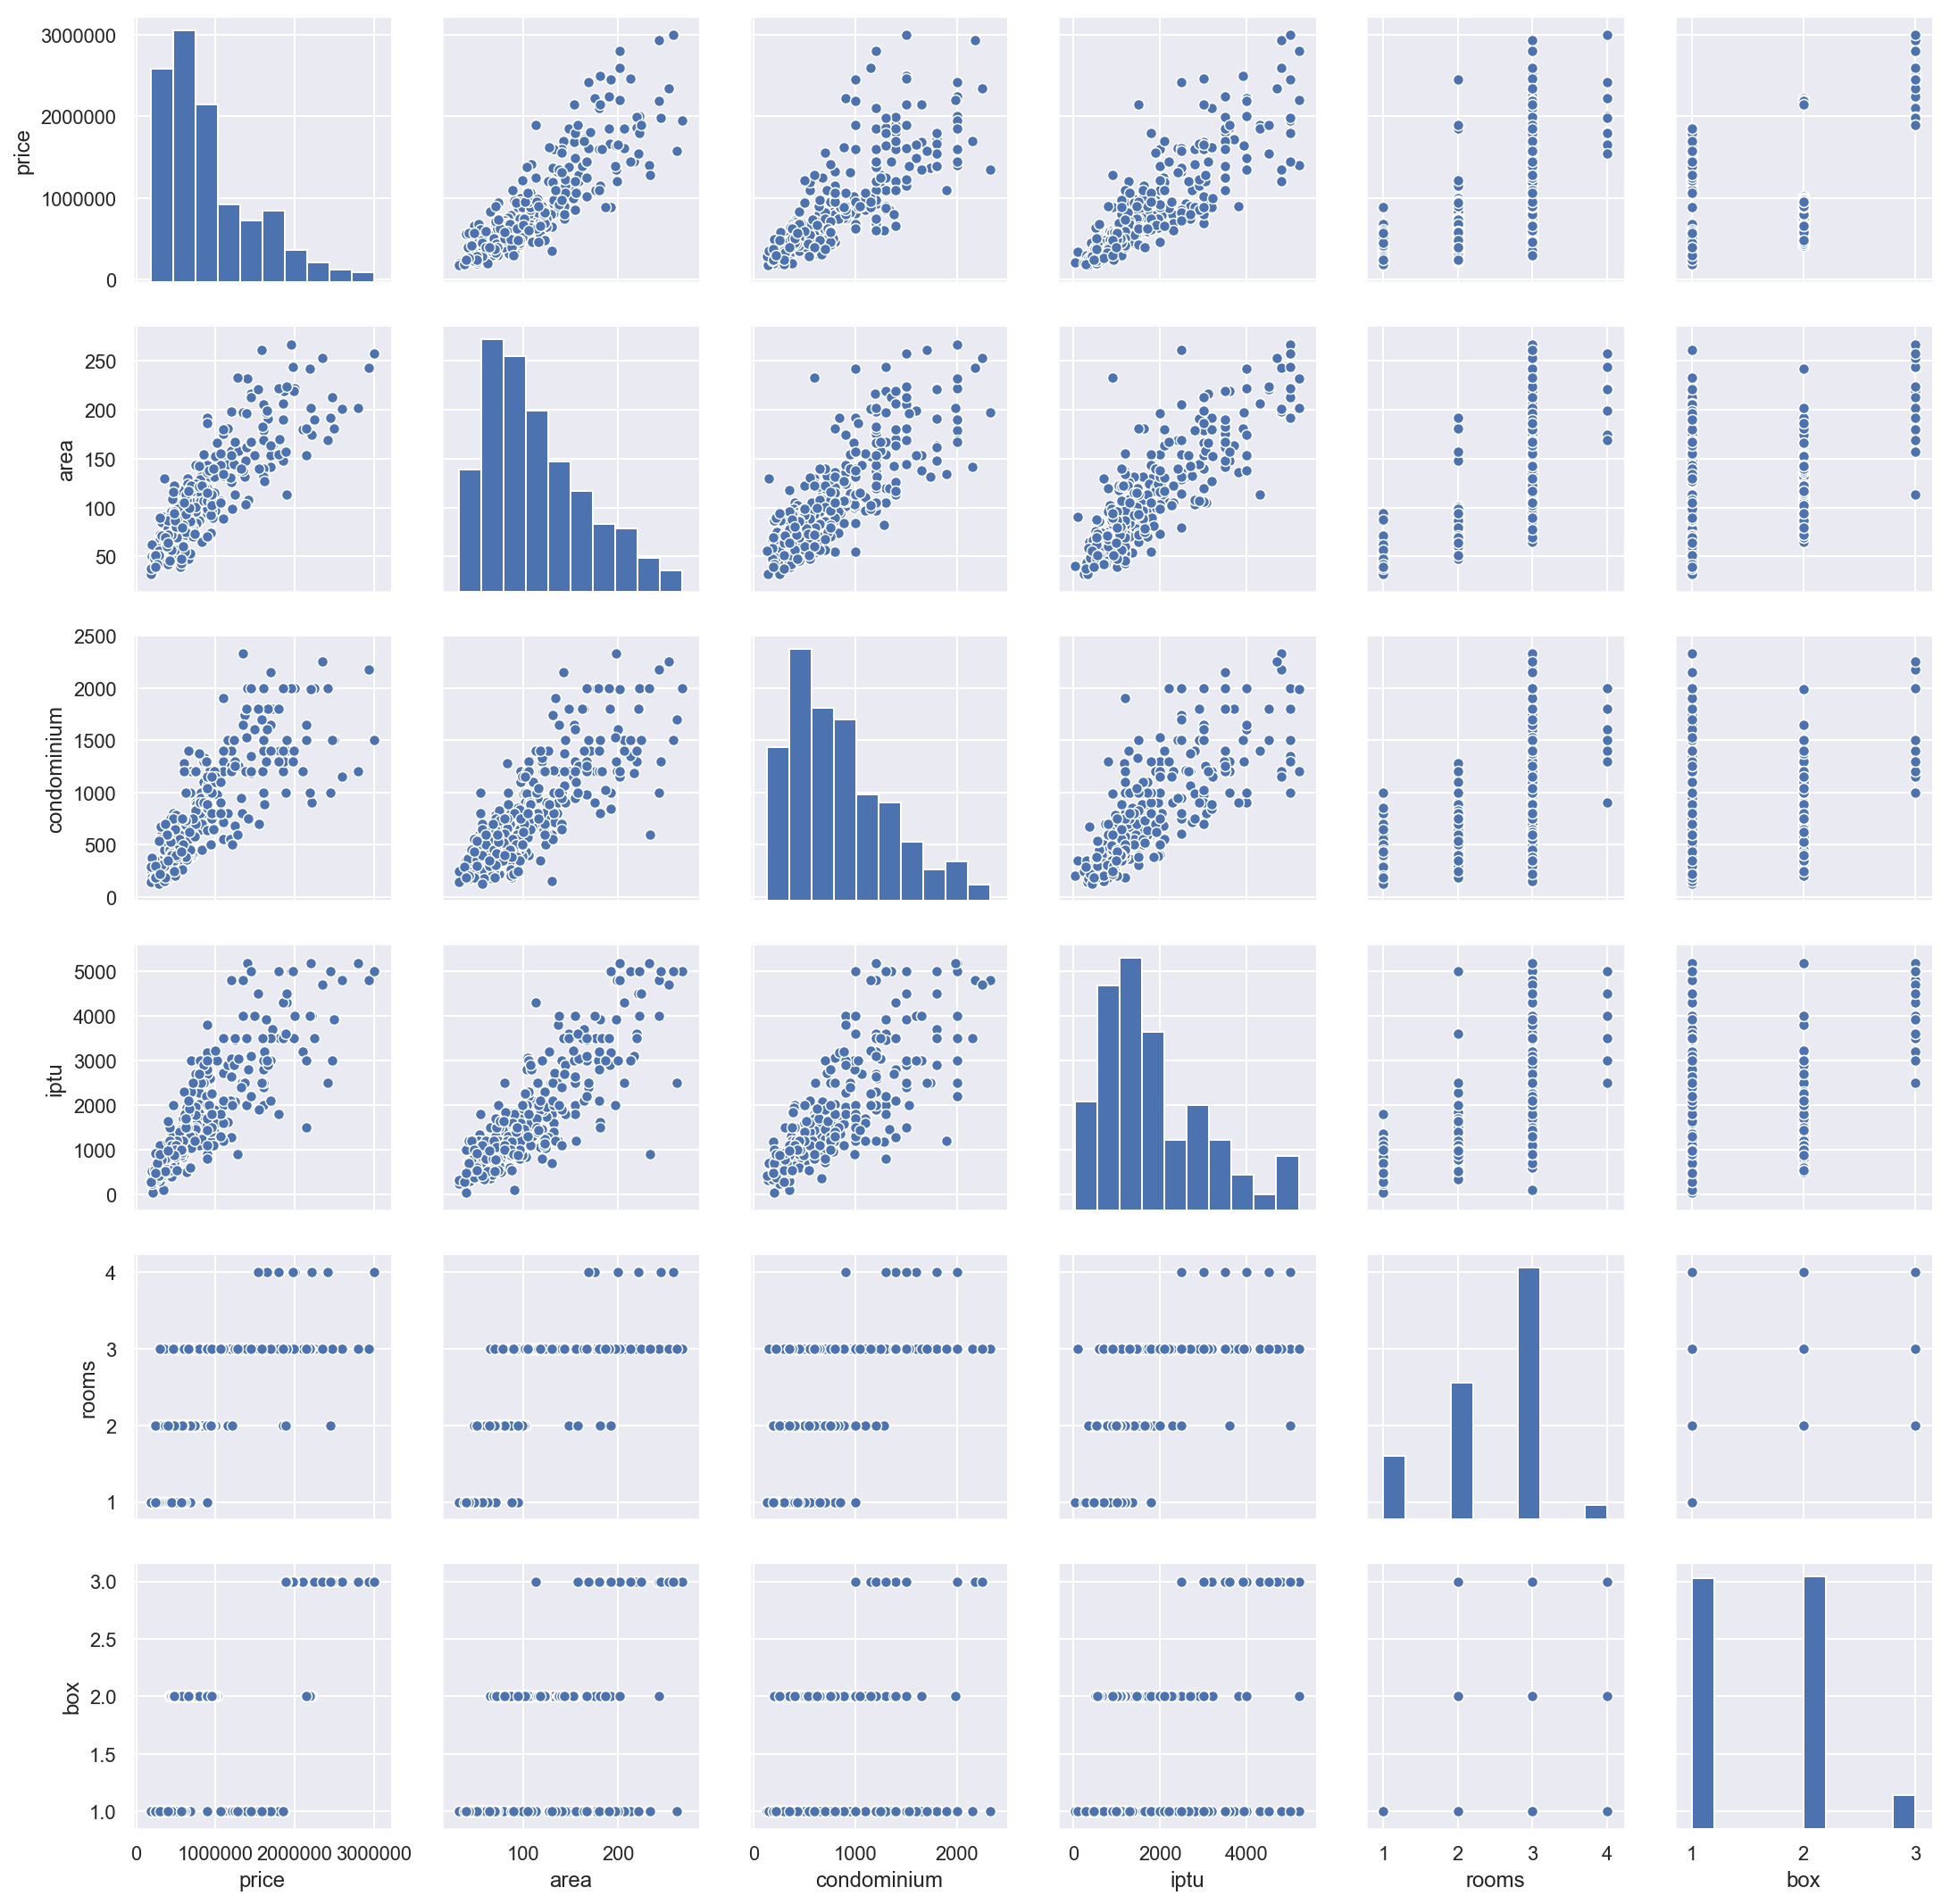

In [171]:
sns.set() #sns.set(font_scale=0.5)
sns.pairplot(df)
plt.show()

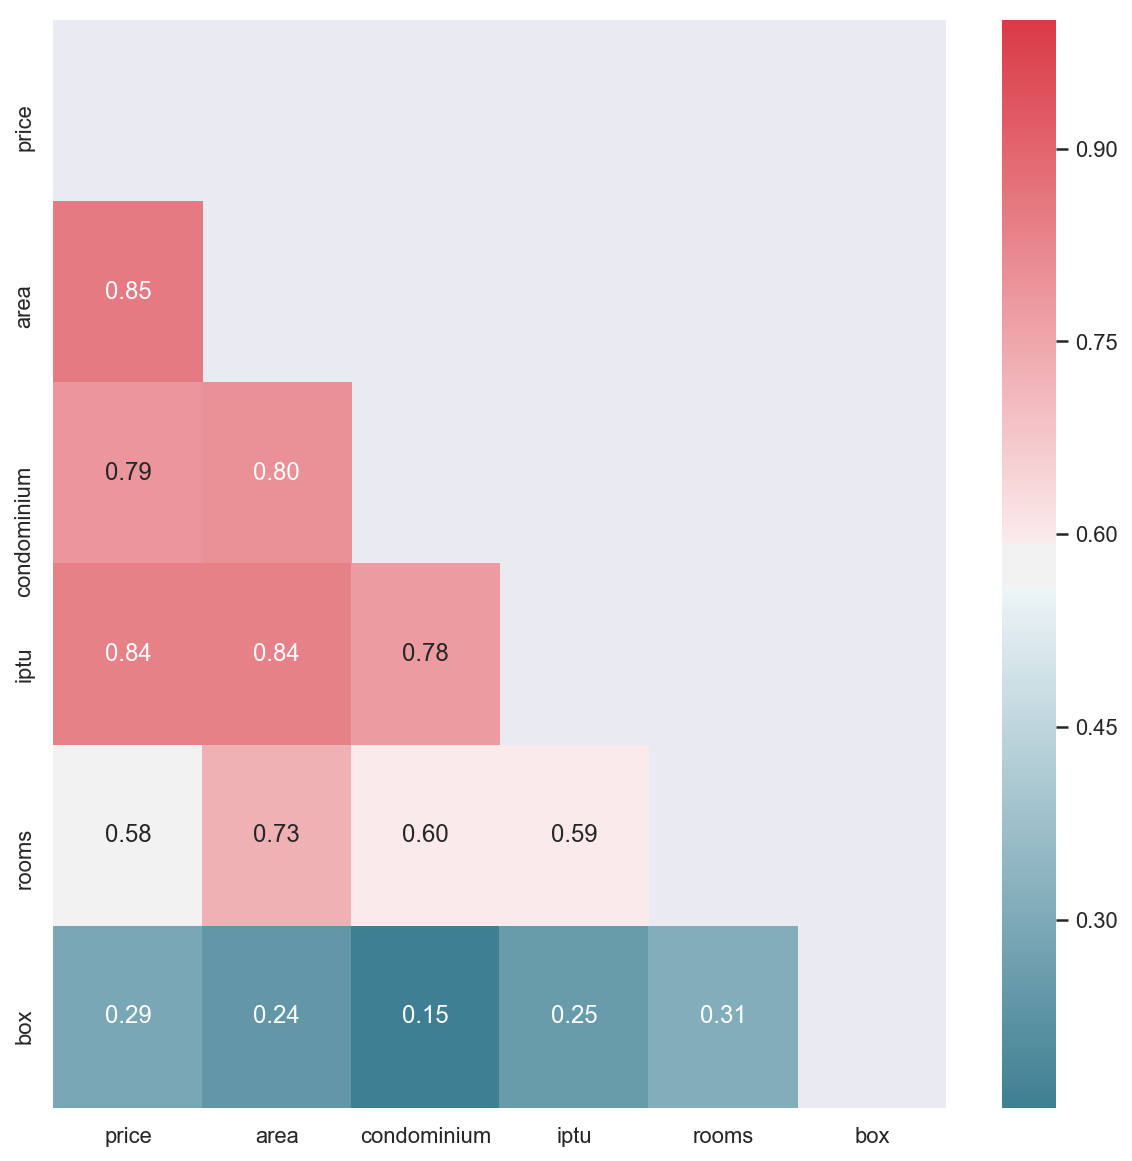

In [172]:
# Analisando as correlações entre as variáveis

corr = df.corr()
fig, ax = plt.subplots(figsize=(10, 10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True

sns.set()
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)

plt.show()

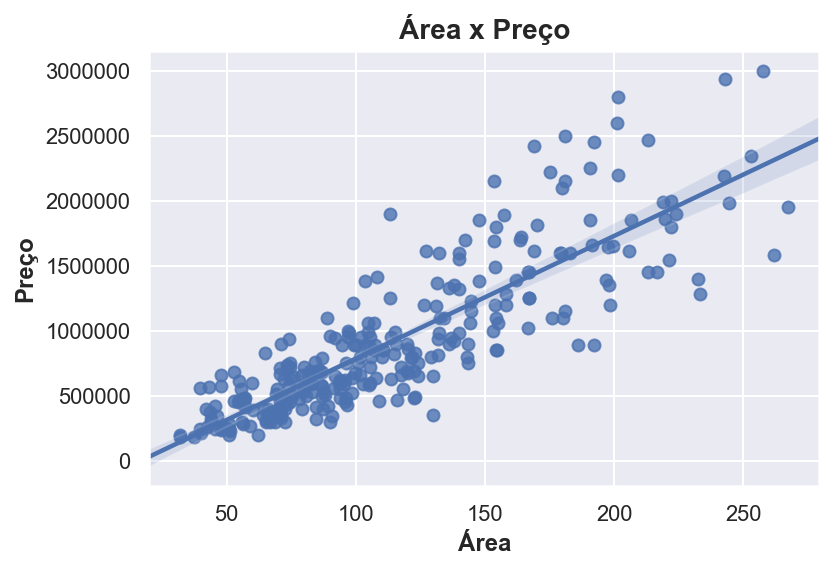

In [173]:
# Área x Preço
sns.set()
sns.regplot(x='area', y='price', data=df)
plt.title('Área x Preço', weight='bold', size=14)
plt.ylabel('Preço', weight='bold', size=12)
plt.xlabel('Área', weight='bold', size=12)
plt.show()

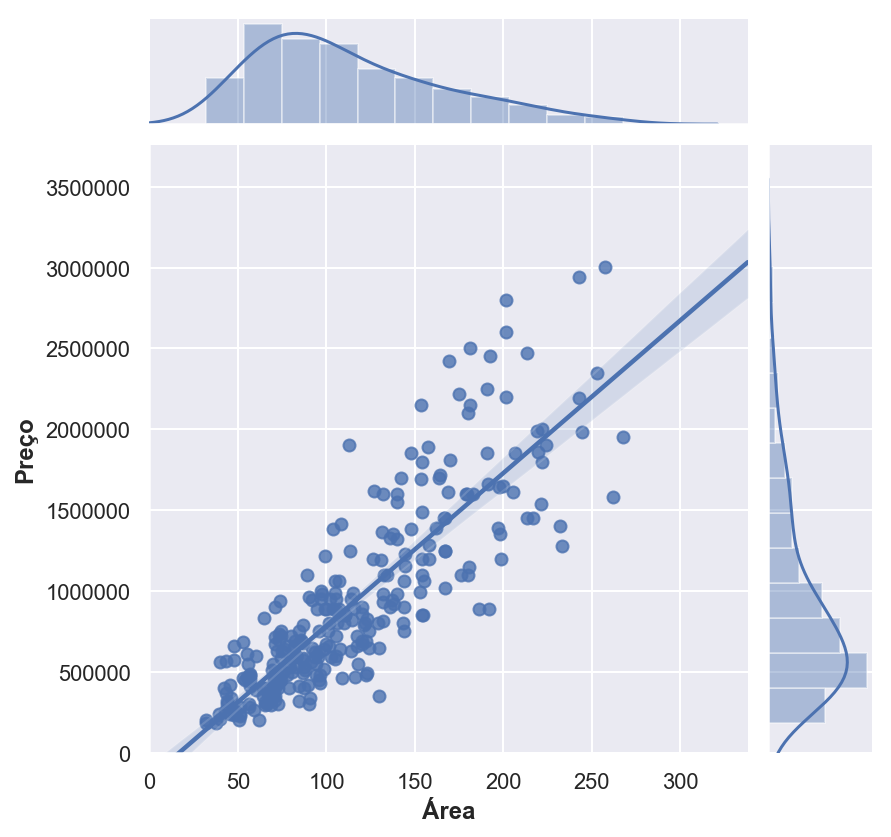

In [174]:
sns.set()
sns.jointplot(x="area", y="price", data=df, kind="reg")
plt.ylabel('Preço', weight='bold', size=12)
plt.xlabel('Área', weight='bold', size=12)
plt.ylim(0, None)
plt.xlim(0, None)
plt.show()

In [175]:
# Calculando o preço do m2
df["price_m2"] = df["price"] / df["area"]

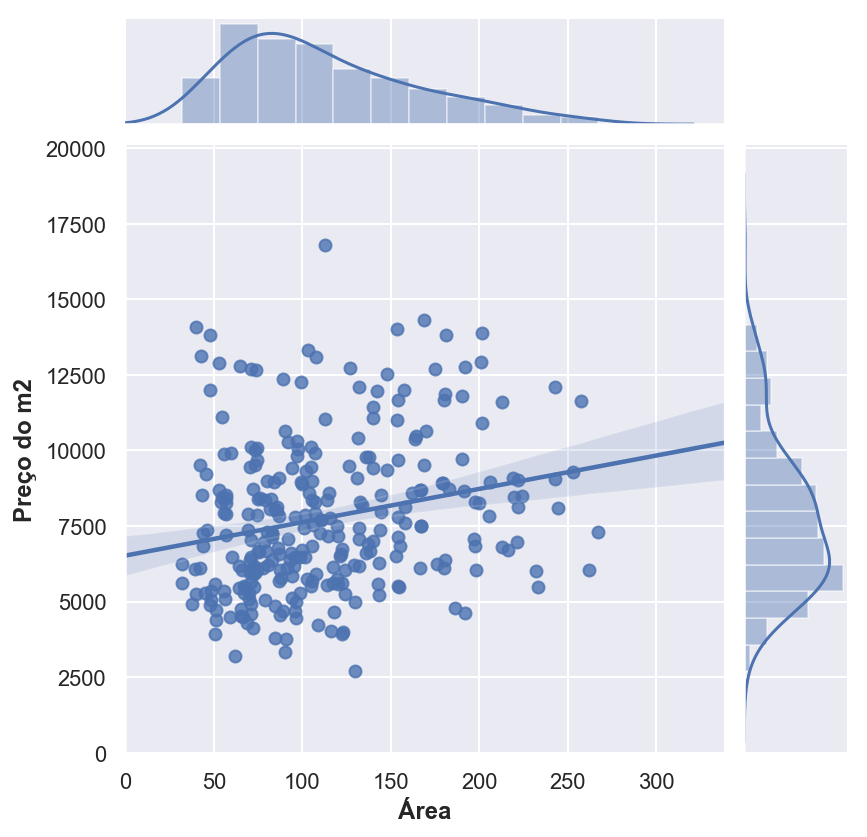

In [176]:
# Área x Preço de m2

sns.set()
sns.jointplot(x="area", y="price_m2", data=df, kind="reg")
plt.ylabel('Preço do m2', weight='bold', size=12)
plt.xlabel('Área', weight='bold', size=12)
plt.ylim(0, None)
plt.xlim(0, None)
plt.show()

### Seção Multivariada

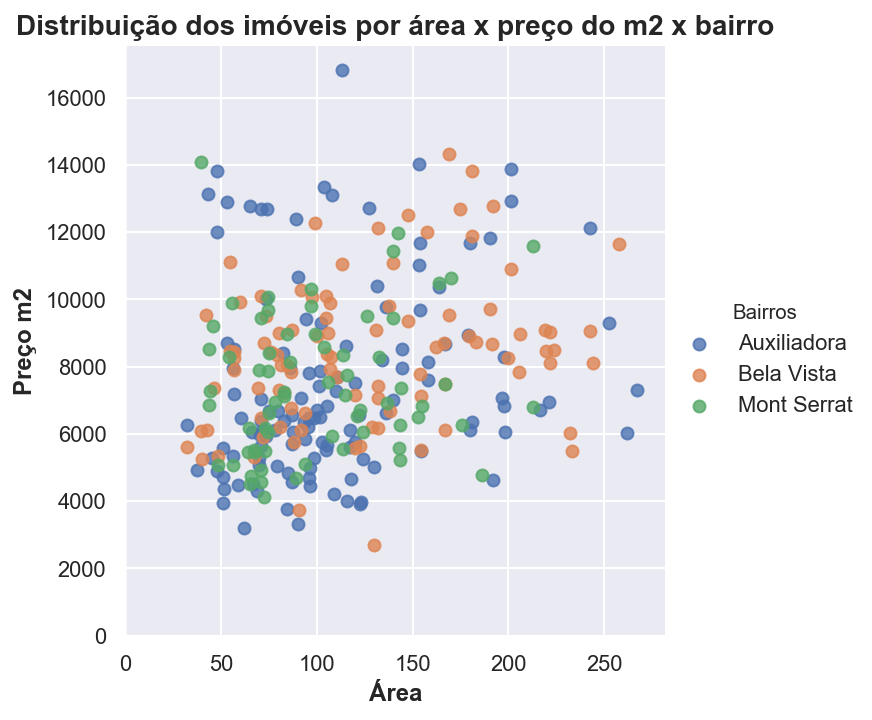

In [178]:
# Distribuição dos imóveis por Área x Preço x Bairro
sns.set()
sns.lmplot(x='area', y='price_m2', data=df,
           fit_reg=False, 
           hue='district')._legend.set_title("Bairros")
 
plt.title('Distribuição dos imóveis por área x preço do m2 x bairro', weight='bold', size=14)
plt.ylabel('Preço m2', weight='bold', size=12)
plt.xlabel('Área', weight='bold', size=12)
plt.ylim(0, None)
plt.xlim(0, None)
plt.show()

In [68]:
# Retirar a variável Preço do m2 do dataframe
# Não nos interessa a análise dela no conjunto
# Visto que ela duplicará a informação sobre preço no modelo

df.drop(['price_m2'], axis = 1, inplace = True)

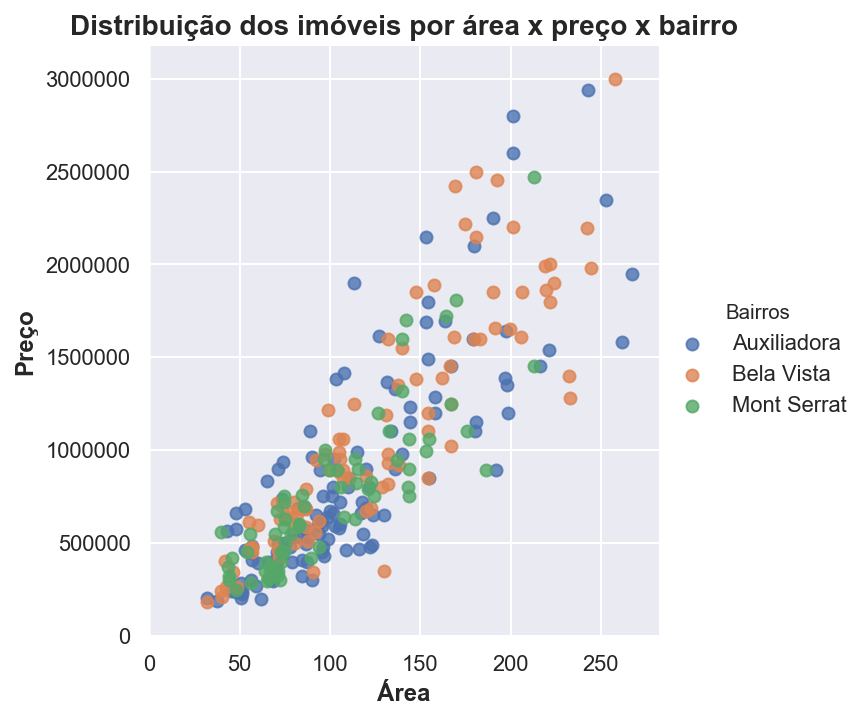

In [69]:
# Distribuição dos imóveis por Área x Preço x Bairro
sns.set()
sns.lmplot(x='area', y='price', data=df,
           fit_reg=False, 
           hue='district')._legend.set_title("Bairros")
 
plt.title('Distribuição dos imóveis por área x preço x bairro', weight='bold', size=14)
plt.ylabel('Preço', weight='bold', size=12)
plt.xlabel('Área', weight='bold', size=12)
plt.ylim(0, None)
plt.xlim(0, None)
plt.show()

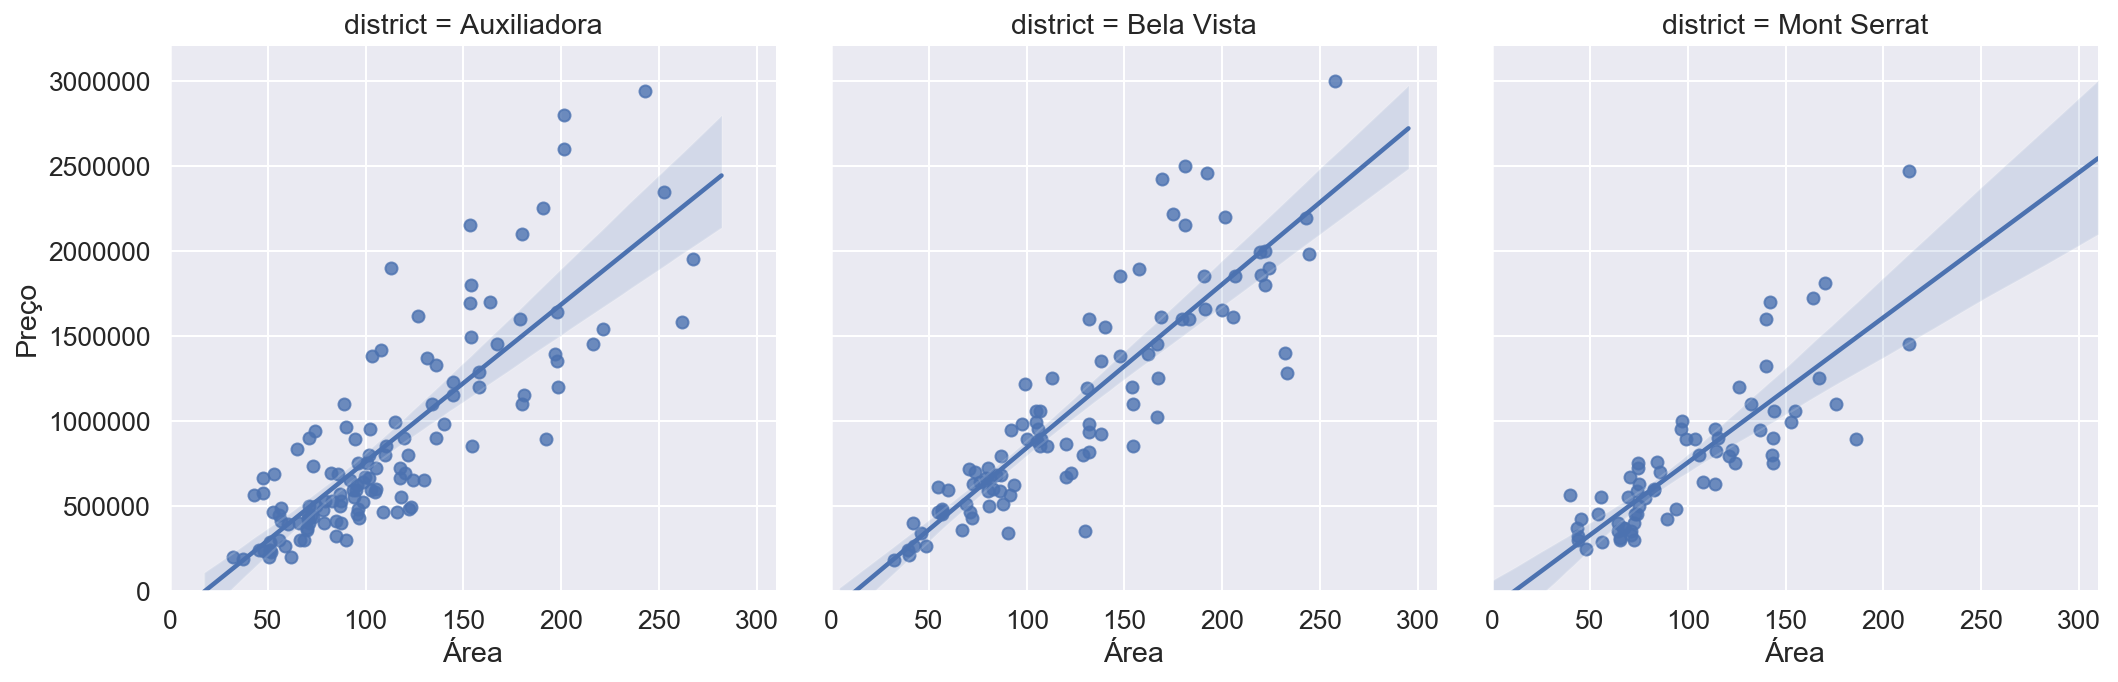

In [70]:
sns.set(font_scale=1.2)
sns.lmplot(x="area", y="price", col="district", 
               data=df, height=5).set_axis_labels("Área", "Preço")
plt.ylim(0, None)
plt.xlim(0, None)
plt.show()

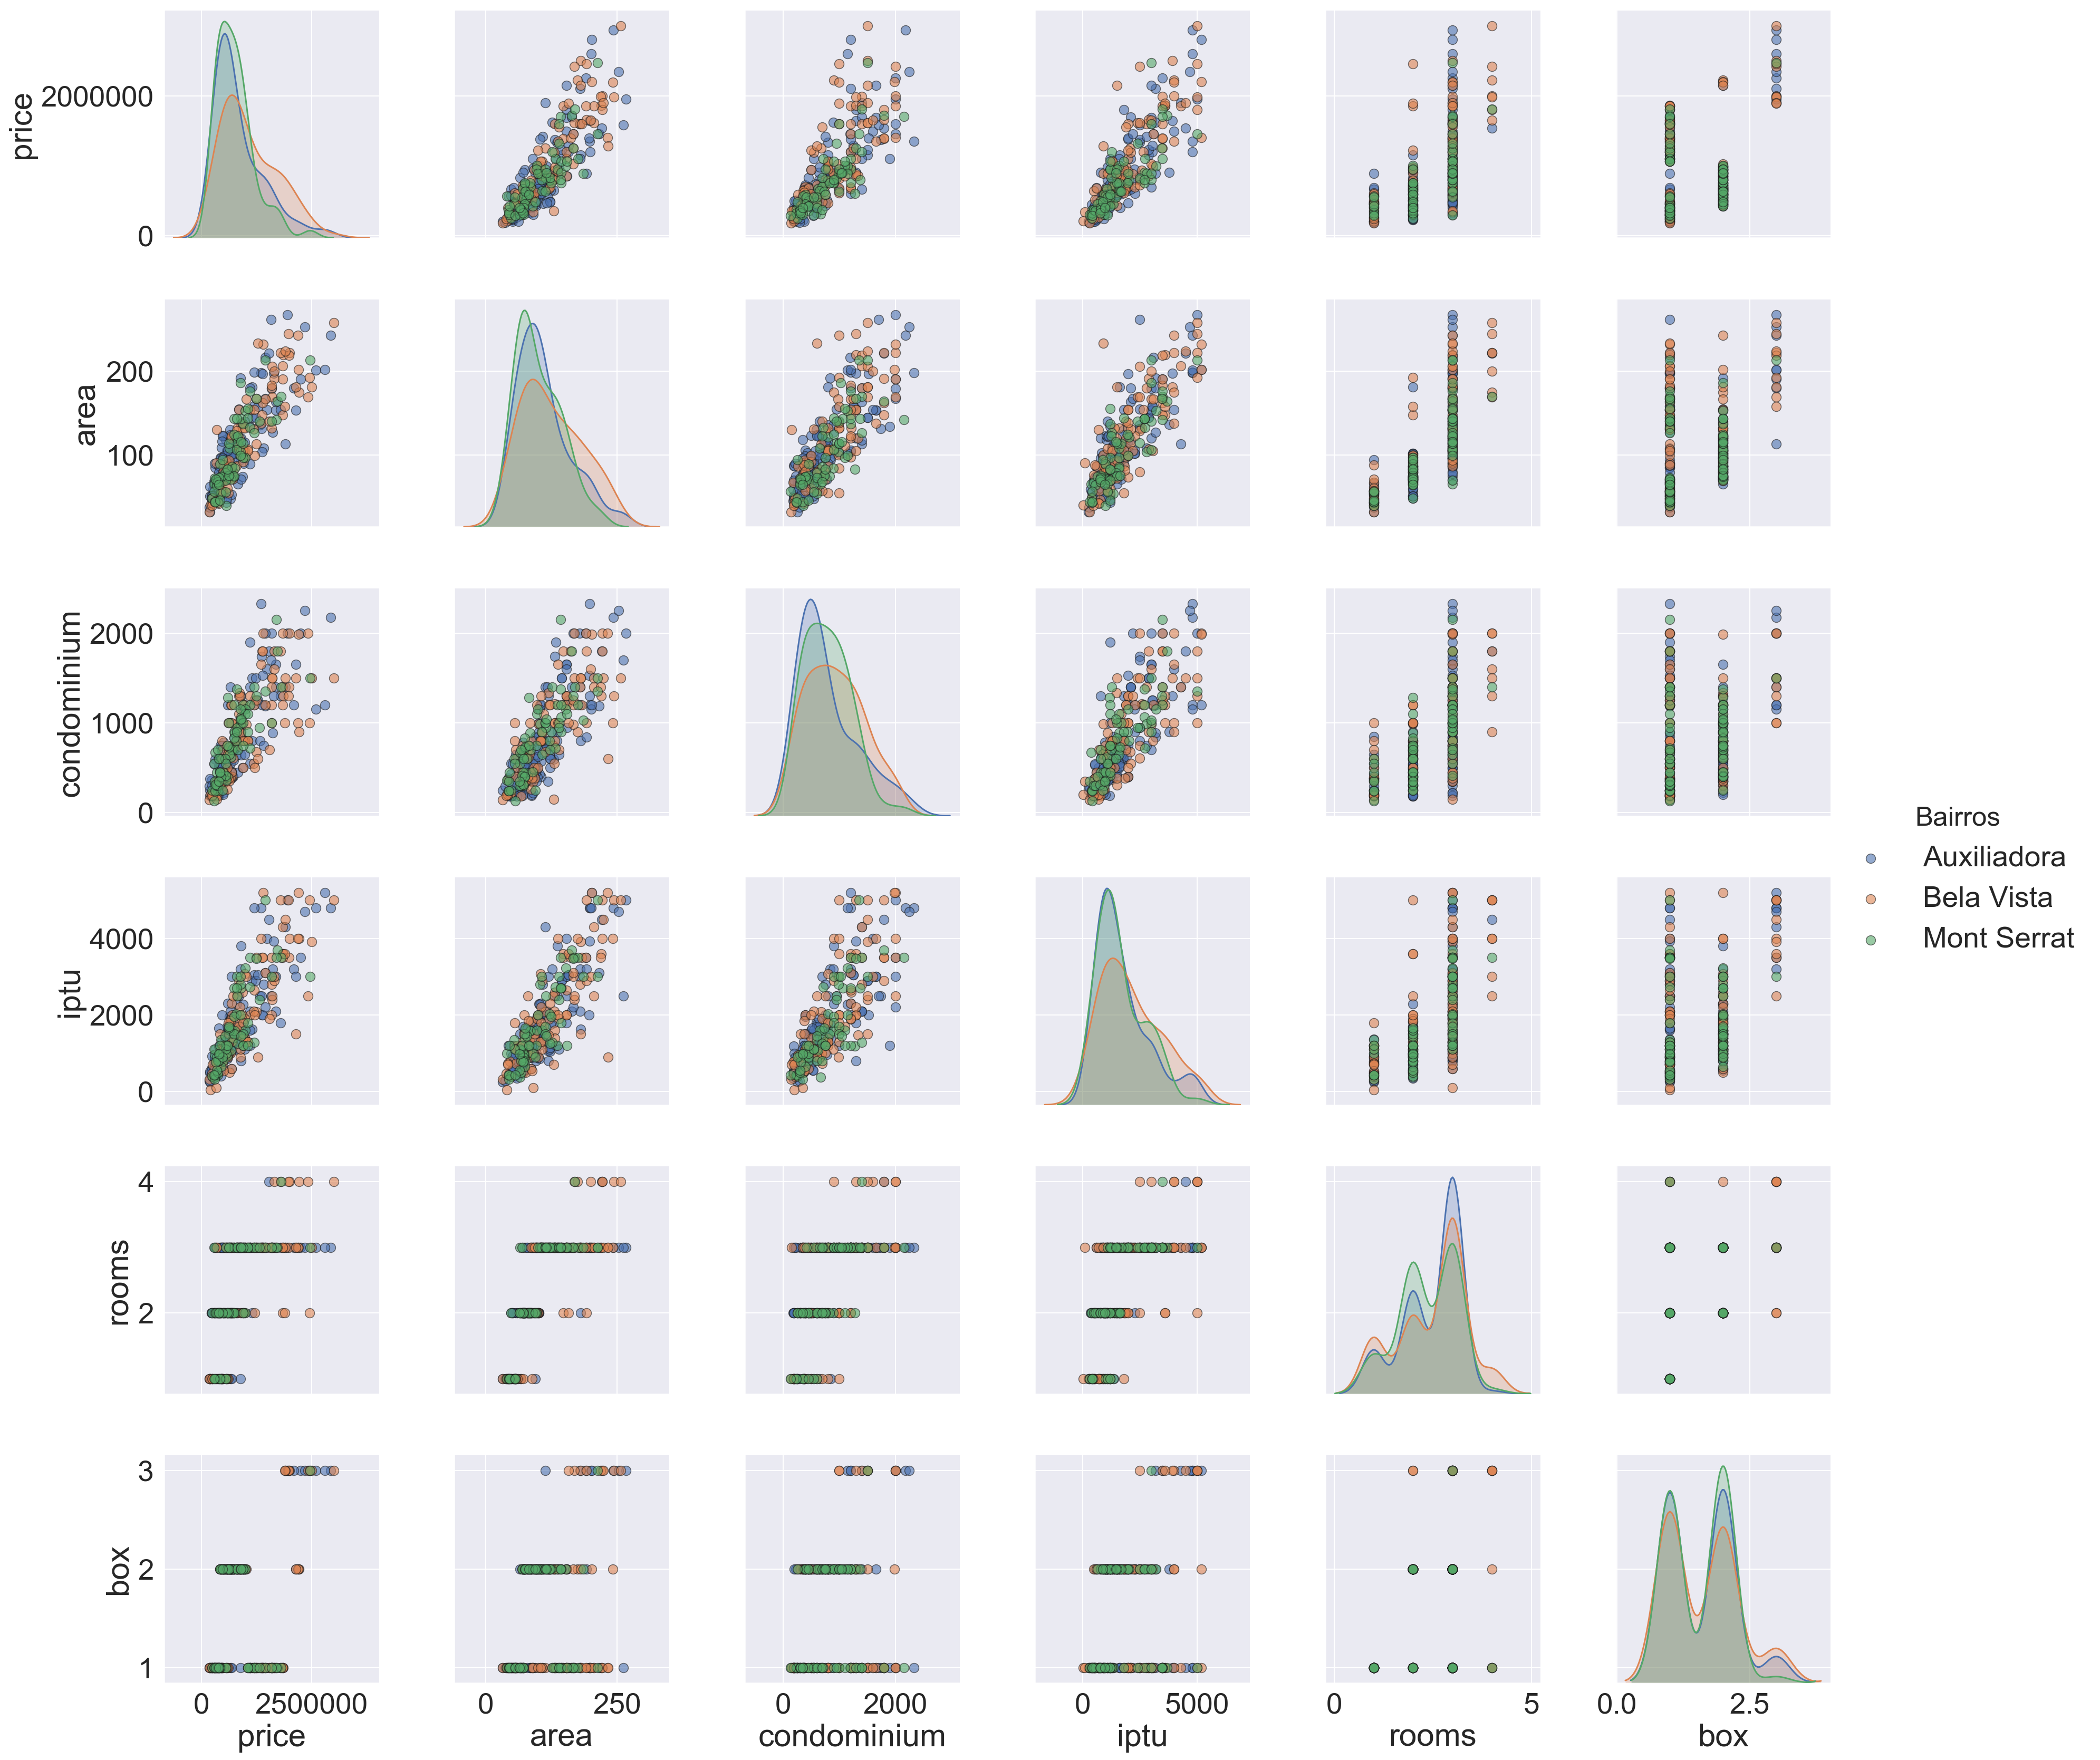

In [71]:
# Pairplot: diferenciação de cor pelos bairros

sns.set(font_scale=2.5)
sns.pairplot(df, hue = 'district', diag_kind = 'kde',
            plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             size = 4)._legend.set_title("Bairros")

plt.show()

## Feature Engineering

In [72]:
# Manter cópia original do df
df_original = df.copy()
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 1 to 576
Data columns (total 7 columns):
price          287 non-null float64
area           287 non-null float64
district       287 non-null category
condominium    287 non-null float64
iptu           287 non-null float64
rooms          287 non-null int64
box            287 non-null int64
dtypes: category(1), float64(4), int64(2)
memory usage: 16.1 KB


In [73]:
# Transformar a variável do bairro em dummies
df = pd.get_dummies(df, columns=features_cat, drop_first=True)

df.head()

price   area  condominium    iptu  rooms  box  district_Bela Vista  \
1  720000.00  74.43       717.00 1400.00      2    2                    0   
2  990000.00 104.83       800.00 3070.00      3    2                    1   
3 1450000.00 216.46      1190.00 3100.00      3    1                    0   
4 1900000.00 113.03      1400.00 4300.00      3    3                    0   
6  370000.00  43.47       239.00  427.00      1    1                    0   

   district_Mont Serrat  
1                     1  
2                     0  
3                     0  
4                     0  
6                     1

In [74]:
# Listando as novas features após dummies
all_variables_list = list(df.columns)
features_list_dum = list(set(all_variables_list) - set(target))
features_list_dum.sort()
print(features_list_dum)

['area', 'box', 'condominium', 'district_Bela Vista', 'district_Mont Serrat', 'iptu', 'rooms']


In [75]:
# Para avaliação do modelo

num_folds = 10
random_state = 42
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)

In [76]:
# Separando treino e teste

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df[features_list_dum], df['price'], test_size=0.25, random_state=random_state, shuffle=True)

In [77]:
# Calculando o modelo de referêcia - Benchmark
# Regressão Linear

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)


print("Benchmark\nRegressão Linear\n")

mse_benchmark = mean_squared_error(y_test, predictions)
print("MSE do benchmark: ", "{0:,.2f}".format(mse_benchmark))

mae_benchmark = mean_absolute_error(y_test, predictions)
print("MAE do benchmark: ", "{0:,.2f}".format(mae_benchmark))

evs_benchmark = explained_variance_score(y_test, predictions)
print("EVS do benchmark: %.2f" % evs_benchmark)

r2_benchmark = r2_score(y_test, predictions)
print("R2 do benchmark: %.2f" % r2_benchmark)

Benchmark
Regressão Linear

MSE do benchmark:  74,061,685,914.85
MAE do benchmark:  200,770.87
EVS do benchmark: 0.76
R2 do benchmark: 0.75


In [85]:
# Algortimos Regressores
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('ABR', AdaBoostRegressor(random_state=random_state)))
models.append(('GBR', GradientBoostingRegressor(random_state=random_state)))

In [86]:
# Avaliação de cada algortimo
results = []
names = []
for name, model in models:
    # "MAE is a better choice" https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print(name, "{0:,.2f}".format(cv_results.mean()))

LR 0.77
LASSO 0.77
EN 0.78
KNN 0.68
CART 0.70
SVR -0.11
ABR 0.82
GBR 0.83


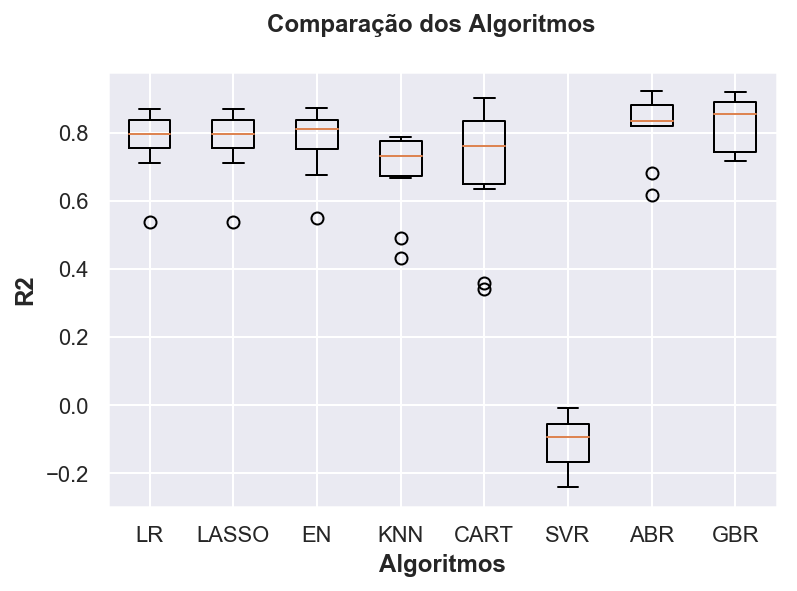

In [89]:
# Compare Algorithms
sns.set()
fig = plt.figure()
fig.suptitle('Comparação dos Algoritmos', weight='bold', size=12)
plt.ylabel('R2', weight='bold', size=12)
plt.xlabel('Algoritmos', weight='bold', size=12)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [90]:
# Tunning GBM - Melhor algoritmo no comparativo anterior

'''
# Configuração inicial
param_grid = {'max_depth':range(5,16,2),
              'max_features':range(1,len(features_list_dum),1),
              'min_samples_leaf':range(30,71,10),
              'min_samples_split':range(200,1001,200),
              'n_estimators':range(20,81,10)
             }
'''

# Configuração final
param_grid = {'max_depth':range(1,10,2),
              'max_features':range(1,len(features_list_dum),1),
              'min_samples_leaf':range(2,10,2),
              'min_samples_split':range(2,20,4),
              'n_estimators':range(2,81,10)
             }

model = GradientBoostingRegressor(random_state=random_state)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=kfold, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print("Best:", "{0:,.2f}\n".format(grid_result.best_score_), grid_result.best_params_)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{0:,.2f}".format(mean), '(' + str("{0:,.2f}".format(stdev)) + ')', param)

Best: 0.86
 {'max_depth': 9, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 32}
0.14 (0.03) {'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2}
0.48 (0.05) {'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 12}
0.68 (0.03) {'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 22}
0.74 (0.04) {'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 32}
0.78 (0.05) {'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 42}
0.80 (0.06) {'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 52}
0.81 (0.06) {'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 62}
0.81 (0.06) {'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 2, 'min_samp

0.78 (0.05) {'max_depth': 1, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 32}
0.80 (0.06) {'max_depth': 1, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 42}
0.81 (0.07) {'max_depth': 1, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 52}
0.81 (0.07) {'max_depth': 1, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 62}
0.81 (0.08) {'max_depth': 1, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 72}
0.17 (0.02) {'max_depth': 1, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 14, 'n_estimators': 2}
0.60 (0.04) {'max_depth': 1, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 14, 'n_estimators': 12}
0.73 (0.05) {'max_depth': 1, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 14, 'n_estimators': 22}
0.78 (0.05) {'max_depth': 1, 'max_features': 5, 'min_samples_leaf': 6, 'm

0.82 (0.07) {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 42}
0.82 (0.07) {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 52}
0.82 (0.07) {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 62}
0.82 (0.07) {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 72}
0.25 (0.05) {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 14, 'n_estimators': 2}
0.74 (0.05) {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 14, 'n_estimators': 12}
0.80 (0.05) {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 14, 'n_estimators': 22}
0.82 (0.06) {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 14, 'n_estimators': 32}
0.82 (0.07) {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 4, 'm

0.74 (0.07) {'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 8, 'min_samples_split': 14, 'n_estimators': 12}
0.81 (0.07) {'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 8, 'min_samples_split': 14, 'n_estimators': 22}
0.82 (0.07) {'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 8, 'min_samples_split': 14, 'n_estimators': 32}
0.81 (0.08) {'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 8, 'min_samples_split': 14, 'n_estimators': 42}
0.81 (0.08) {'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 8, 'min_samples_split': 14, 'n_estimators': 52}
0.81 (0.08) {'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 8, 'min_samples_split': 14, 'n_estimators': 62}
0.81 (0.08) {'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 8, 'min_samples_split': 14, 'n_estimators': 72}
0.26 (0.05) {'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 8, 'min_samples_split': 18, 'n_estimators': 2}
0.75 (0.07) {'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 8, 'm

0.85 (0.05) {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 42}
0.85 (0.05) {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 52}
0.85 (0.05) {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 62}
0.85 (0.05) {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 72}
0.27 (0.04) {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 2}
0.79 (0.06) {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 12}
0.83 (0.05) {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 22}
0.84 (0.05) {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 32}
0.84 (0.05) {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 2, 'min_s

0.84 (0.05) {'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 18, 'n_estimators': 62}
0.84 (0.05) {'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 18, 'n_estimators': 72}
0.27 (0.05) {'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 2}
0.77 (0.05) {'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 12}
0.84 (0.04) {'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 22}
0.85 (0.04) {'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 32}
0.85 (0.04) {'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 42}
0.85 (0.04) {'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 52}
0.85 (0.04) {'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 4, 'min_sam

0.73 (0.06) {'max_depth': 9, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 14, 'n_estimators': 12}
0.81 (0.06) {'max_depth': 9, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 14, 'n_estimators': 22}
0.83 (0.05) {'max_depth': 9, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 14, 'n_estimators': 32}
0.84 (0.05) {'max_depth': 9, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 14, 'n_estimators': 42}
0.83 (0.05) {'max_depth': 9, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 14, 'n_estimators': 52}
0.84 (0.04) {'max_depth': 9, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 14, 'n_estimators': 62}
0.84 (0.04) {'max_depth': 9, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 14, 'n_estimators': 72}
0.24 (0.04) {'max_depth': 9, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 18, 'n_estimators': 2}
0.72 (0.06) {'max_depth': 9, 'max_features': 1, 'min_samples_leaf': 4, 'm

0.85 (0.05) {'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 32}
0.84 (0.05) {'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 42}
0.84 (0.06) {'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 52}
0.84 (0.06) {'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 62}
0.84 (0.06) {'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 72}
0.28 (0.04) {'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 2}
0.79 (0.05) {'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 12}
0.85 (0.05) {'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 22}
0.85 (0.05) {'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 6, 'min_sa

In [91]:
print("Best R2:", "{0:,.2f}\n".format(grid_result.best_score_))
for item, value in grid_result.best_params_.items():
    print (item, value)

Best R2: 0.86

max_depth 9
max_features 3
min_samples_leaf 4
min_samples_split 10
n_estimators 32


In [95]:
# Modelo Final

model = GradientBoostingRegressor(max_depth=grid_result.best_params_['max_depth'],
                                  max_features=grid_result.best_params_['max_features'],
                                  min_samples_leaf=grid_result.best_params_['min_samples_leaf'],
                                  min_samples_split=grid_result.best_params_['min_samples_split'],
                                  n_estimators=grid_result.best_params_['n_estimators'],
                                  random_state=random_state
                                 )
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse_final_model = mean_squared_error(y_test, predictions)
print("MSE: ", "{0:,.2f}".format(mse_final_model))

mae_final_model = mean_absolute_error(y_test, predictions)
print("MAE do benchmark: ", "{0:,.2f}".format(mae_final_model))

evs_final_model = explained_variance_score(y_test, predictions)
print("EVS do benchmark: %.2f" % evs_final_model)

r2_final_model = r2_score(y_test, predictions)
print("R2: %.2f" % r2_final_model)

MSE:  54,877,748,414.29
MAE do benchmark:  166,155.67
EVS do benchmark: 0.82
R2: 0.82


In [96]:
# Comparando: benchmark x modelo final

print("MSE do benchmark: ", "{0:,.2f}".format(mse_benchmark))
print("MAE do benchmark: ", "{0:,.2f}".format(mae_benchmark))
print("EVS do benchmark: %.2f" % evs_benchmark)
print("R2 do benchmark: %.2f" % r2_benchmark)

print("\nMSE do modelo final: ", "{0:,.2f}".format(mse_final_model))
print("MAE do modelo final: ", "{0:,.2f}".format(mae_final_model))
print("EVS do modelo final: %.2f" % evs_final_model)
print('R2 do modelo final: ', "{0:,.2f}".format(r2_final_model))


MSE do benchmark:  74,061,685,914.85
MAE do benchmark:  200,770.87
EVS do benchmark: 0.76
R2 do benchmark: 0.75

MSE do modelo final:  54,877,748,414.29
MAE do modelo final:  166,155.67
EVS do modelo final: 0.82
R2 do modelo final:  0.82


In [97]:
# Identificação das importâncias das features
# Fonte: https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd

importances = list(model.feature_importances_)

importances.sort(reverse=True)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_list_dum, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Atributo: {:20} Importância: {}'.format(*pair)) for pair in feature_importances];

Atributo: area                 Importância: 0.34
Atributo: box                  Importância: 0.31
Atributo: condominium          Importância: 0.15
Atributo: district_Bela Vista  Importância: 0.14
Atributo: district_Mont Serrat Importância: 0.05
Atributo: iptu                 Importância: 0.01
Atributo: rooms                Importância: 0.0


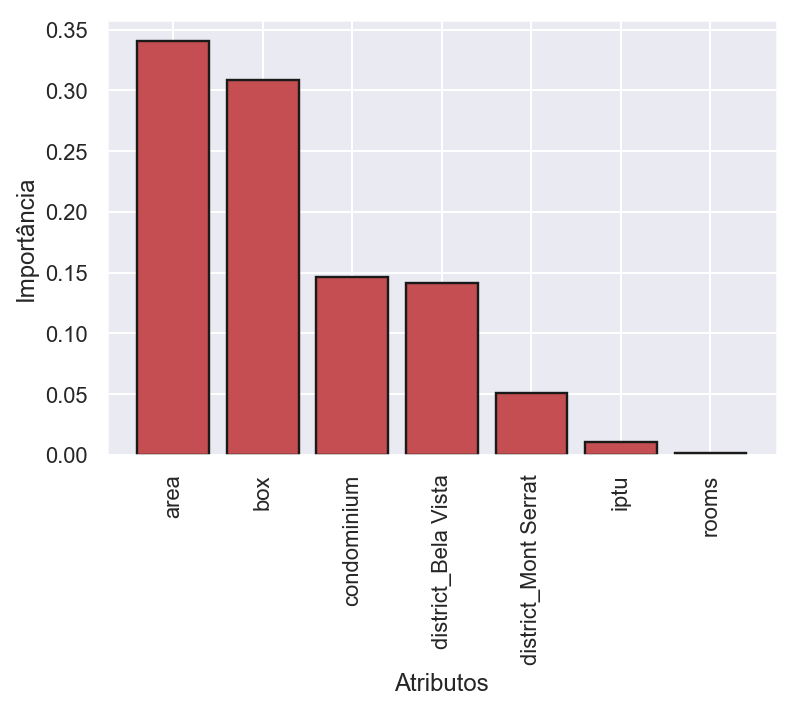

In [107]:
# Identificação gráfica das importâncias das features
# Fonte: https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

plt.xticks(x_values, features_list_dum, rotation='vertical')

plt.ylabel('Importância'); 
plt.xlabel('Atributos'); 
#plt.title('Importância dos Atributos');

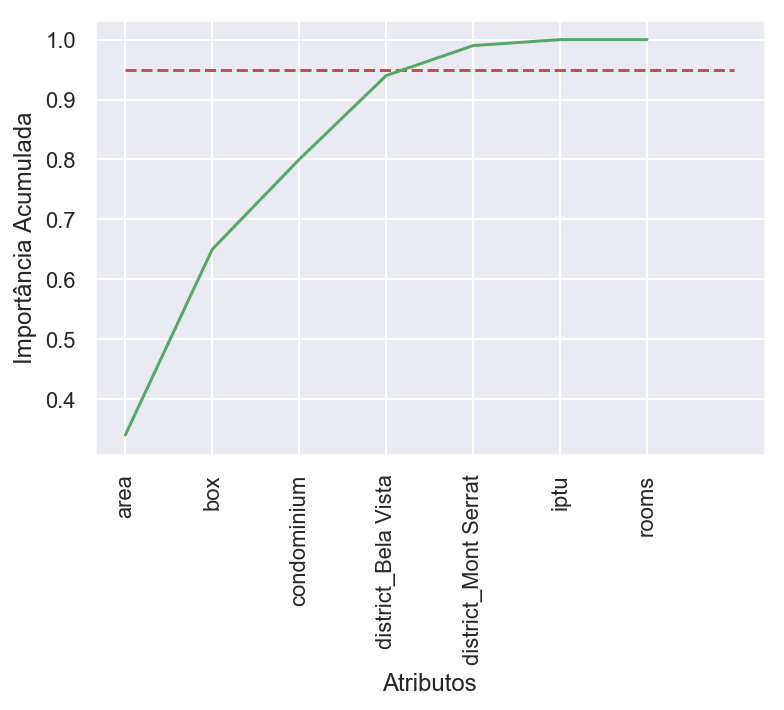

In [108]:
# Identificação gráfica da importância acumulada dos atributos
# Fonte: https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd

sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

cumulative_importances = np.cumsum(sorted_importances)

plt.plot(x_values, cumulative_importances, 'g-')

plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

plt.xticks(x_values, sorted_features, rotation = 'vertical')

plt.xlabel('Atributos'); plt.ylabel('Importância Acumulada'); 
#plt.title('Importância Acumulada dos Atributos');

### Para prever o preço de um determinado imóvel

In [100]:
print("Ordem das variáveis:\n\n", features_list_dum)

Ordem das variáveis:

 ['area', 'box', 'condominium', 'district_Bela Vista', 'district_Mont Serrat', 'iptu', 'rooms']


In [109]:
# prevendo o preço de um imóvel: 119m2, 2 boxes, 750 de condomínio, 2100 de iptu, 3 quartos em Mont Serrat

imovel = [[119, 2,750,0,1,2100,3]]

prev = int(model.predict(imovel))

print ("Preço previsto:", "{0:,.2f}".format(prev))


Preço previsto: 713,420.00


In [102]:
df_2box_montserrat = df_original.query("(district == 'Mont Serrat' & box == '2' & rooms == '3')")
df_2box_montserrat

price   area     district  condominium    iptu  rooms  box
41  790000.00 121.18  Mont Serrat       798.00 2030.00      3    2
71  945000.00 136.87  Mont Serrat      1200.00 1200.00      3    2
156 900000.00 143.59  Mont Serrat      1063.00 2700.00      3    2
165 890000.00 103.68  Mont Serrat       990.00 2800.00      3    2
215 750000.00 124.12  Mont Serrat       900.00 1964.00      3    2
218 820000.00 114.60  Mont Serrat       950.00 2500.00      3    2
259 639000.00 107.83  Mont Serrat       650.00 1600.00      3    2
268 995000.00 152.93  Mont Serrat      1150.00 3220.00      3    2
272 750000.00 143.56  Mont Serrat      1200.00 2700.00      3    2
276 550000.00  69.60  Mont Serrat       410.00 1200.00      3    2
287 825000.00 122.70  Mont Serrat       700.00 1250.00      3    2
288 800000.00 106.00  Mont Serrat       900.00 3000.00      3    2
350 890000.00  99.23  Mont Serrat      1150.00 2000.00      3    2
491 799000.00 143.00  Mont Serrat      1377.00 2700.00      3    2
525 630000.00 113.75  Mont Serrat      1000.00 1700.00      3    2
533 890000.00 186.13  Mont Serrat      1027.00 3000.00      3    2
556 950000.00 113.76  Mont Serrat      1000.00 1500.00      3    2
558 897000.00 115.59  Mont Serrat      1040.00 1451.00      3    2

In [103]:
df_2box_montserrat.shape[0]

18

In [104]:
# Identificando a concorrência
# boxplot: preço

x = df_2box_montserrat.district

trace0 = go.Box(
    y=df_2box_montserrat.price,
    x=x,
    name='kale',
    marker=dict(
        color='blue'
    )
)

data = [trace0]
layout = go.Layout(
    yaxis=dict(
        title='preço de venda',
        zeroline=False
    ),
    boxmode='group'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

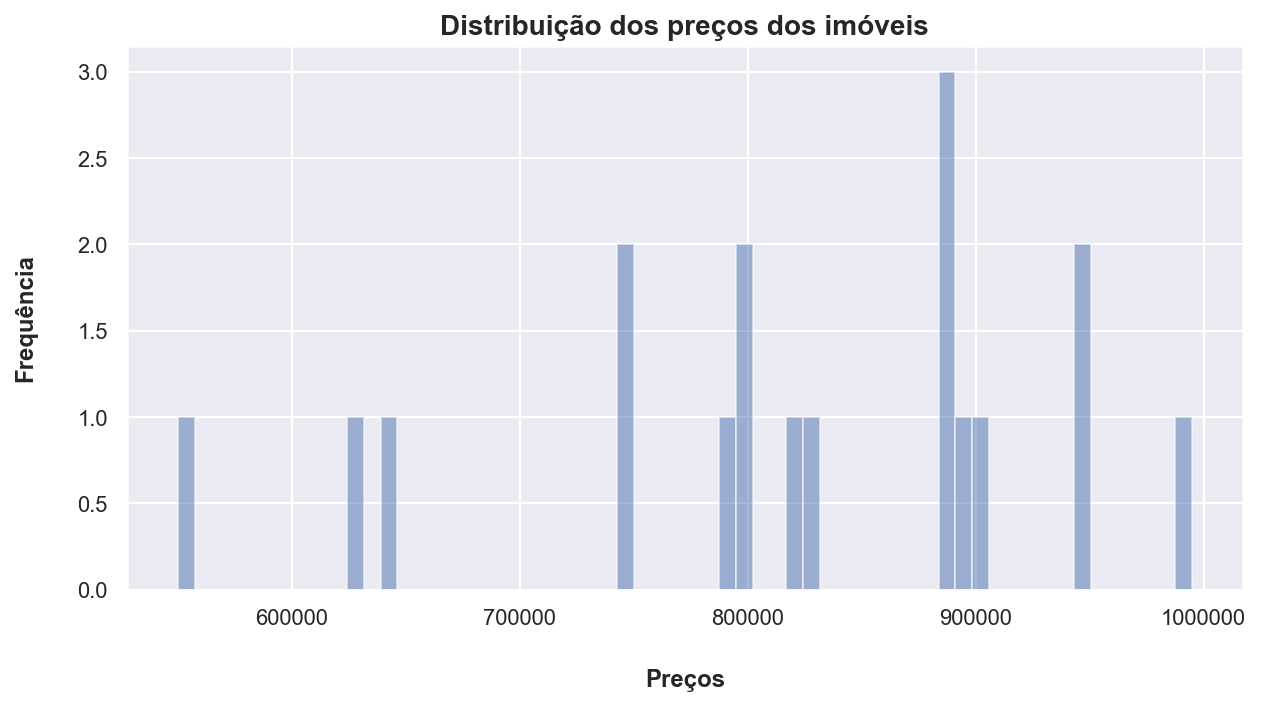

In [105]:
# Histograma: preço
sns.set()
ax = df_2box_montserrat['price'].plot.hist(bins=60, alpha=0.5, figsize=(10, 5))
ax.set_title('Distribuição dos preços dos imóveis', weight='bold', size=14)
ax.set_ylabel("Frequência", labelpad=20, weight='bold', size=12)
ax.set_xlabel('Preços', labelpad=20, weight='bold', size=12)
plt.show()